In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel, TFTModel, TCNModel, DLinearModel, NLinearModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [11]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [12]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nlinear_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NLinear",
        shared_weights=False,
        normalize=model_args['normalize'],
        const_init=model_args['const_init'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [13]:
def build_fit_nlinear_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
   
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="DLinear",
        shared_weights=False,
        const_init=model_args['const_init'],
        normalize=model_args['normalize'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [14]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),#setting 168 is not a good option here as convolutions take time reducing this to 80
    "out_len":tune.randint(1,24),
    "normalize": tune.choice([True, False]),
    "const_init":tune.choice([True, False]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nlinear_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="dlinear_tune_cov",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-11 08:02:32 (running for 00:00:00.15)
Memory usage on this node: 73.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 1/100 (1 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-----------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |        lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-----------+--------------|
| build_fit_nlinear_model_1e763b28 | RUNNING  | 172.31.10.87:2698682 |       42 |         6 | Fals

(build_fit_nlinear_model pid=2698682) Global seed set to 42
(build_fit_nlinear_model pid=2698682) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2698682)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2698682) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2698682)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2698682) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698682) GPU available: 

== Status ==
Current time: 2023-07-11 08:02:42 (running for 00:00:10.12)
Memory usage on this node: 76.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------|
| build_fit_nlinear_model_1e763b28 | RUNNING  | 172.31.10.87:2698

(build_fit_nlinear_model pid=2698935) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2698935)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2698935) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2698935)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2698931) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecat

(build_fit_nlinear_model pid=2698935) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698933) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698933) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698933) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698933) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698933) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698933) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698944) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698933) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2698933) 
(build_

(build_fit_nlinear_model pid=2698938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2698938)   rank_zero_warn(
(build_fit_nlinear_model pid=2698938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2698938)   rank_zero_warn(
(build_fit_nlinear_model pid=2698938) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:02:48 (running for 00:00:15.87)
Memory usage on this node: 89.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------|
| build_fit_nlinear_model_1e763b28 | RUNNING  | 172.31.10.87:2698

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]


(build_fit_nlinear_model pid=2698933) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698933) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698933) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698933) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698933) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698933) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698933) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 277.14it/s]


(build_fit_nlinear_model pid=2698944) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698944) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698944) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698944) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698944) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698944) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698944) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2698942) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698942) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.23it/s]
== Status ==
Current time: 2023-07-11 08:03:08 (running for 00:00:36.51)
Memory usage on this node: 85.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d68cf839 with q_smape=107.79508076584072 and parameters={'in_len': 166, 'out_len': 1, 'normalize': True, 'const_init': False, 'lr': 0.0005749681588803279, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 9/100 (8 RUNNING, 1 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   

(build_fit_nlinear_model pid=2701303) Global seed set to 42
(build_fit_nlinear_model pid=2701303) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2701303)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2701303) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2701303)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.96it/s]


(build_fit_nlinear_model pid=2698993) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698993) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698993) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698993) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698993) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698993) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698993) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2701303) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701303) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.68it/s]


(build_fit_nlinear_model pid=2698682) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698682) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698682) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698682) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698682) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698682) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698682) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2701790) Global seed set to 42
(build_fit_nlinear_model pid=2701790) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

(build_fit_nlinear_model pid=2701790) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2701790)   rank_zero_warn(
(build_fit_nlinear_model pid=2701790) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2701790)   rank_zero_warn(
(build_fit_nlinear_model pid=2701790) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:03:23 (running for 00:00:51.52)
Memory usage on this node: 90.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1e763b28 with q_smape=22.79710358909415 and parameters={'in_len': 42, 'out_len': 6, 'normalize': False, 'const_init': False, 'lr': 0.022306711559932496, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_si

(build_fit_nlinear_model pid=2702338) Global seed set to 42
(build_fit_nlinear_model pid=2702338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2702338)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2702338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2702338)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2702338) Auto select gpus: [0]
(build_fit_nlinear_model pid=2702338) GPU available: 

== Status ==
Current time: 2023-07-11 08:03:29 (running for 00:00:56.96)
Memory usage on this node: 93.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1e763b28 with q_smape=22.79710358909415 and parameters={'in_len': 42, 'out_len': 6, 'normalize': False, 'const_init': False, 'lr': 0.022306711559932496, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_si

== Status ==
Current time: 2023-07-11 08:03:44 (running for 00:01:11.98)
Memory usage on this node: 102.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1e763b28 with q_smape=22.79710358909415 and parameters={'in_len': 42, 'out_len': 6, 'normalize': False, 'const_init': False, 'lr': 0.022306711559932496, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2701303) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701303) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2701303) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2701303) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2701303) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2701303) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2701303) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.06it/s]


(build_fit_nlinear_model pid=2701788) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701788) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2701788) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2701788) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2701788) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2701788) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2701788) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2698938) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698938) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.61it/s]
== Status ==
Current time: 2023-07-11 08:03:54 (running for 00:01:21.99)
Memory usage on this node: 100.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c6a494fc with q_smape=19.418229203960284 and parameters={'in_len': 114, 'out_len': 23, 'normalize': False, 'const_init': True, 'lr': 0.009124244257285686, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2705215) Global seed set to 42
(build_fit_nlinear_model pid=2705215) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2705215)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705215) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2705215)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705213) Global seed set to 42
(build_fit_nlinear_model pid=2705213) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 08:04:03 (running for 00:01:31.53)
Memory usage on this node: 94.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c6a494fc with q_smape=19.418229203960284 and parameters={'in_len': 114, 'out_len': 23, 'normalize': False, 'const_init': True, 'lr': 0.009124244257285686, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2705841) Global seed set to 42
(build_fit_nlinear_model pid=2705841) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2705841)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705841) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2705841)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2705841) Auto select gpus: [0]
(build_fit_nlinear_model pid=2705841) GPU available: 

== Status ==
Current time: 2023-07-11 08:04:09 (running for 00:01:37.12)
Memory usage on this node: 96.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c6a494fc with q_smape=19.418229203960284 and parameters={'in_len': 114, 'out_len': 23, 'normalize': False, 'const_init': True, 'lr': 0.009124244257285686, 'batch_size': 32}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2698935) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698935) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698935) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698935) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698935) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698935) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698935) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.23it/s]


(build_fit_nlinear_model pid=2701792) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701792) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2701792) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2701792) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2701792) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2701792) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2701792) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2705213) Auto select gpus: [0]
(build_fit_nlinear_model pid=2705213) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.06it/s]
== Status ==
Current time: 2023-07-11 08:04:15 (running for 00:01:43.09)
Memory usage on this node: 96.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2707318) Global seed set to 42
(build_fit_nlinear_model pid=2707318) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2707318)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707318) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2707318)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707318) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707318) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.49it/s]
== Status ==
Current time: 2023-07-11 08:04:23 (running for 00:01:51.57)
Memory usage on this node: 94.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2707916) Global seed set to 42
(build_fit_nlinear_model pid=2707916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2707916)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707916) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2707916)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2707914) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707914) GPU available: 

== Status ==
Current time: 2023-07-11 08:04:31 (running for 00:01:59.55)
Memory usage on this node: 98.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2709124) Global seed set to 42
(build_fit_nlinear_model pid=2709124) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2709124)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709124) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2709124)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2709124) Auto select gpus: [0]
(build_fit_nlinear_model pid=2709124) GPU available: 

== Status ==
Current time: 2023-07-11 08:04:37 (running for 00:02:05.53)
Memory usage on this node: 97.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.31it/s]


(build_fit_nlinear_model pid=2705841) Auto select gpus: [0]
(build_fit_nlinear_model pid=2705841) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2705841) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2705841) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2705841) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2705841) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2705841) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2707318) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707318) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.88it/s]
== Status ==
Current time: 2023-07-11 08:04:48 (running for 00:02:16.53)
Memory usage on this node: 97.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |  

(build_fit_nlinear_model pid=2710842) Global seed set to 42


== Status ==
Current time: 2023-07-11 08:04:54 (running for 00:02:22.26)
Memory usage on this node: 100.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

(build_fit_nlinear_model pid=2710842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2710842)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2710842)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2710842) Auto select gpus: [0]
(build_fit_nlinear_model pid=2710842) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2710842

== Status ==
Current time: 2023-07-11 08:04:59 (running for 00:02:27.55)
Memory usage on this node: 101.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

(build_fit_nlinear_model pid=2711256) Global seed set to 42
(build_fit_nlinear_model pid=2711256) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2711256)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711256) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2711256)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711256) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711256) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.95it/s]


(build_fit_nlinear_model pid=2698931) Auto select gpus: [0]
(build_fit_nlinear_model pid=2698931) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2698931) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2698931) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2698931) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2698931) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2698931) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:05:09 (running for 00:02:37.56)
Memory usage on this node: 99.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2711744) Global seed set to 42
(build_fit_nlinear_model pid=2711744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2711744)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2711744)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2711744) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711744) GPU available: 

== Status ==
Current time: 2023-07-11 08:05:15 (running for 00:02:43.09)
Memory usage on this node: 101.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

== Status ==
Current time: 2023-07-11 08:05:25 (running for 00:02:53.10)
Memory usage on this node: 100.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

(build_fit_nlinear_model pid=2707914) Auto select gpus: [0]
(build_fit_nlinear_model pid=2707914) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2707914) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2707914) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2707914) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2707914) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2707914) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:05:35 (running for 00:03:03.55)
Memory usage on this node: 98.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2713028) Global seed set to 42
(build_fit_nlinear_model pid=2713028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2713028)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2713028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2713028)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2713028) Auto select gpus: [0]
(build_fit_nlinear_model pid=2713028) GPU available: 

== Status ==
Current time: 2023-07-11 08:05:41 (running for 00:03:09.55)
Memory usage on this node: 100.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

== Status ==
Current time: 2023-07-11 08:05:51 (running for 00:03:19.57)
Memory usage on this node: 100.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

== Status ==
Current time: 2023-07-11 08:06:02 (running for 00:03:29.59)
Memory usage on this node: 93.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:06:12 (running for 00:03:39.60)
Memory usage on this node: 93.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:06:22 (running for 00:03:49.62)
Memory usage on this node: 94.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:06:32 (running for 00:03:59.64)
Memory usage on this node: 94.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:06:42 (running for 00:04:09.65)
Memory usage on this node: 94.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:06:52 (running for 00:04:19.67)
Memory usage on this node: 94.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:07:02 (running for 00:04:29.69)
Memory usage on this node: 92.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:07:12 (running for 00:04:39.71)
Memory usage on this node: 93.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:07:22 (running for 00:04:49.73)
Memory usage on this node: 100.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batc

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.72it/s]


(build_fit_nlinear_model pid=2713028) Auto select gpus: [0]
(build_fit_nlinear_model pid=2713028) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2713028) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2713028) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2713028) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2713028) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2713028) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:07:33 (running for 00:05:01.58)
Memory usage on this node: 96.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2726717) Global seed set to 42
(build_fit_nlinear_model pid=2726717) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2726717)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2726717) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2726717)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2726717) Auto select gpus: [0]
(build_fit_nlinear_model pid=2726717) GPU available: 

== Status ==
Current time: 2023-07-11 08:07:40 (running for 00:05:07.75)
Memory usage on this node: 91.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:07:50 (running for 00:05:17.77)
Memory usage on this node: 91.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:08:00 (running for 00:05:27.79)
Memory usage on this node: 89.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:08:10 (running for 00:05:37.80)
Memory usage on this node: 88.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2701790) Auto select gpus: [0]
(build_fit_nlinear_model pid=2701790) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2701790) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2701790) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2701790) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2701790) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2701790) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:08:19 (running for 00:05:47.58)
Memory usage on this node: 87.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2730793) Global seed set to 42
(build_fit_nlinear_model pid=2730793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2730793)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2730793) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2730793)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2730793) Auto select gpus: [0]
(build_fit_nlinear_model pid=2730793) GPU available: 

== Status ==
Current time: 2023-07-11 08:08:25 (running for 00:05:52.96)
Memory usage on this node: 87.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:08:35 (running for 00:06:02.98)
Memory usage on this node: 88.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:08:45 (running for 00:06:12.99)
Memory usage on this node: 87.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:08:55 (running for 00:06:23.01)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2710842) Auto select gpus: [0]
(build_fit_nlinear_model pid=2710842) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2710842) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2710842) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2710842) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2710842) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2710842) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:09:00 (running for 00:06:28.57)
Memory usage on this node: 85.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (8 RUNNING, 19 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q

(build_fit_nlinear_model pid=2732354) Global seed set to 42
(build_fit_nlinear_model pid=2732354) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2732354)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2732354) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2732354)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2732354) Auto select gpus: [0]
(build_fit_nlinear_model pid=2732354) GPU available: 

== Status ==
Current time: 2023-07-11 08:09:11 (running for 00:06:38.60)
Memory usage on this node: 85.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2709124) Auto select gpus: [0]
(build_fit_nlinear_model pid=2709124) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2709124) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2709124) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2709124) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2709124) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2709124) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 301.40it/s]
== Status ==
Current time: 2023-07-11 08:09:25 (running for 00:06:52.59)
Memory usage on this node: 85.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2732923) Global seed set to 42
(build_fit_nlinear_model pid=2732923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2732923)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2732923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2732923)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2732923) Auto select gpus: [0]
(build_fit_nlinear_model pid=2732923) GPU available: 

== Status ==
Current time: 2023-07-11 08:09:30 (running for 00:06:57.77)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:09:40 (running for 00:07:07.78)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:09:50 (running for 00:07:17.79)
Memory usage on this node: 85.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2702338) Auto select gpus: [0]


== Status ==
Current time: 2023-07-11 08:09:55 (running for 00:07:22.82)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2702338) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2702338) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2702338) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2702338) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2702338) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2702338) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 298.48it/s]
== Status ==
Current time: 2023-07-11 08:10:01 (running for 00:07:28.59)
Memory usage on this node: 83.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2733469) Global seed set to 42
(build_fit_nlinear_model pid=2733469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2733469)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2733469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2733469)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2733469) Auto select gpus: [0]
(build_fit_nlinear_model pid=2733469) GPU available: 

== Status ==
Current time: 2023-07-11 08:10:06 (running for 00:07:33.79)
Memory usage on this node: 86.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:10:16 (running for 00:07:43.80)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:10:26 (running for 00:07:53.82)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:10:36 (running for 00:08:03.84)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:10:46 (running for 00:08:13.85)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:10:56 (running for 00:08:23.87)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:11:06 (running for 00:08:33.88)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:11:16 (running for 00:08:43.90)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2711744) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711744) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2711744) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2711744) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2711744) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2711744) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2711744) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.77it/s]


(build_fit_nlinear_model pid=2732923) Auto select gpus: [0]
(build_fit_nlinear_model pid=2732923) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2732923) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2732923) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2732923) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2732923) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2732923) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.01it/s]
== Status ==
Current time: 2023-07-11 08:11:22 (running for 00:08:50.42)
Memory usage on this node: 85.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2734160) Global seed set to 42
(build_fit_nlinear_model pid=2734160) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2734160)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2734160) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2734160)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2734160) Auto select gpus: [0]
(build_fit_nlinear_model pid=2734160) GPU available: 

== Status ==
Current time: 2023-07-11 08:11:29 (running for 00:08:56.62)
Memory usage on this node: 83.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2734407) Global seed set to 42
(build_fit_nlinear_model pid=2734407) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2734407)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2734407) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2734407)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2734407) Auto select gpus: [0]
(build_fit_nlinear_model pid=2734407) GPU available: 

== Status ==
Current time: 2023-07-11 08:11:34 (running for 00:09:01.87)
Memory usage on this node: 85.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:11:44 (running for 00:09:11.89)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.63it/s]


(build_fit_nlinear_model pid=2733469) Auto select gpus: [0]
(build_fit_nlinear_model pid=2733469) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2733469) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2733469) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2733469) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2733469) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2733469) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2734407) Auto select gpus: [0]
(build_fit_nlinear_model pid=2734407) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.40it/s]
== Status ==
Current time: 2023-07-11 08:11:58 (running for 00:09:25.88)
Memory usage on this node: 85.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2735258) Global seed set to 42
(build_fit_nlinear_model pid=2735258) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2735258)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2735258) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2735258)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2735258) Auto select gpus: [0]
(build_fit_nlinear_model pid=2735258) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.30it/s]


(build_fit_nlinear_model pid=2734160) Auto select gpus: [0]
(build_fit_nlinear_model pid=2734160) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2734160) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2734160) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2734160) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2734160) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2734160) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2735258) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_

== Status ==
Current time: 2023-07-11 08:12:07 (running for 00:09:34.61)
Memory usage on this node: 84.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2735675) Global seed set to 42
(build_fit_nlinear_model pid=2735675) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2735675)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2735675) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2735675)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2735505) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/m

== Status ==
Current time: 2023-07-11 08:12:12 (running for 00:09:39.79)
Memory usage on this node: 85.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:12:22 (running for 00:09:49.80)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

== Status ==
Current time: 2023-07-11 08:12:32 (running for 00:09:59.82)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2735675) Auto select gpus: [0]
(build_fit_nlinear_model pid=2735675) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2735675) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2735675) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2735675) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2735675) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2735675) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.66it/s]
Predicting: 0it [00:00, ?it/s]del pid=2735258) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2735258) Auto select gpus: [0]
(build_fit_nlinear_model pid=2735258) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2735258) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2735258) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2735258) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2735258) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2735258) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.41it/s]
== Status ==
Current time: 2023-07-11 08:12:38 (running for 00:10:05.86)
Memory usage on this node: 85.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2736366) Global seed set to 42
(build_fit_nlinear_model pid=2736366) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2736366)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2736366) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2736366)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2736366) Auto select gpus: [0]
(build_fit_nlinear_model pid=2736366) GPU available: 

== Status ==
Current time: 2023-07-11 08:12:45 (running for 00:10:12.63)
Memory usage on this node: 83.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2736613) Global seed set to 42
(build_fit_nlinear_model pid=2736613) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2736613)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2736613) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2736613)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2736613) Auto select gpus: [0]
(build_fit_nlinear_model pid=2736613) GPU available: 

== Status ==
Current time: 2023-07-11 08:12:50 (running for 00:10:17.99)
Memory usage on this node: 85.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


(build_fit_nlinear_model pid=2736366) Auto select gpus: [0]
(build_fit_nlinear_model pid=2736366) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2736366) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2736366) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2736366) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2736366) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2736366) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.91it/s]


(build_fit_nlinear_model pid=2735505) Auto select gpus: [0]
(build_fit_nlinear_model pid=2735505) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2735505) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2735505) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2735505) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2735505) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2735505) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:13:01 (running for 00:10:29.03)
Memory usage on this node: 85.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2737361) Global seed set to 42
(build_fit_nlinear_model pid=2737361) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2737361)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2737361) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2737361)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2737361) Auto select gpus: [0]
(build_fit_nlinear_model pid=2737361) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.33it/s]


(build_fit_nlinear_model pid=2736613) Auto select gpus: [0]
(build_fit_nlinear_model pid=2736613) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2736613) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2736613) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2736613) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2736613) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2736613) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:13:08 (running for 00:10:35.64)
Memory usage on this node: 83.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2737766) Global seed set to 42
(build_fit_nlinear_model pid=2737766) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2737766)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2737766) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2737766)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2737766) Auto select gpus: [0]
(build_fit_nlinear_model pid=2737766) GPU available: 

== Status ==
Current time: 2023-07-11 08:13:17 (running for 00:10:44.64)
Memory usage on this node: 83.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2738091) Global seed set to 42
(build_fit_nlinear_model pid=2738091) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2738091)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2738091) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2738091)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2738091) Auto select gpus: [0]
(build_fit_nlinear_model pid=2738091) GPU available: 

== Status ==
Current time: 2023-07-11 08:13:22 (running for 00:10:49.64)
Memory usage on this node: 83.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2737361) Auto select gpus: [0]
(build_fit_nlinear_model pid=2737361) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2737361) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2737361) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2737361) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2737361) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2737361) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.78it/s]


(build_fit_nlinear_model pid=2726717) Auto select gpus: [0]
(build_fit_nlinear_model pid=2726717) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2726717) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2726717) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2726717) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2726717) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2726717) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2737766) Auto select gpus: [0]
(build_fit_nlinear_model pid=2737766) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.98it/s]
== Status ==
Current time: 2023-07-11 08:13:35 (running for 00:11:03.50)
Memory usage on this node: 83.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |  

(build_fit_nlinear_model pid=2738889) Global seed set to 42
(build_fit_nlinear_model pid=2738889) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2738889)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2738889) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2738889)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2738889) Auto select gpus: [0]
(build_fit_nlinear_model pid=2738889) GPU available: 

== Status ==
Current time: 2023-07-11 08:13:43 (running for 00:11:10.67)
Memory usage on this node: 81.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2739373) Global seed set to 42
(build_fit_nlinear_model pid=2739373) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2739373)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2739373) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2739373)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2739371) Global seed set to 42
(build_fit_nlinear_model pid=2739371) /home/ubuntu/an

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.48it/s]


(build_fit_nlinear_model pid=2739373) Auto select gpus: [0]
(build_fit_nlinear_model pid=2739373) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2739373) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2739373) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2739373) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2739373) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2739373) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2739373) 
(build_fit_nlinear_model pid=2739373)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2739373) -----

== Status ==
Current time: 2023-07-11 08:13:49 (running for 00:11:16.64)
Memory usage on this node: 83.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2740071) Auto select gpus: [0]
(build_fit_nlinear_model pid=2740071) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2740071) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2740071) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2740071) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2740071) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2740071) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2740071) 
(build_fit_nlinear_model pid=2740071)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2740071) -----

== Status ==
Current time: 2023-07-11 08:13:54 (running for 00:11:21.65)
Memory usage on this node: 87.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2738889) Auto select gpus: [0]
(build_fit_nlinear_model pid=2738889) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2738889) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2738889) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2738889) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2738889) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2738889) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:14:01 (running for 00:11:28.65)
Memory usage on this node: 83.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2740576) Global seed set to 42
(build_fit_nlinear_model pid=2740576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2740576)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2740576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2740576)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2740576) Auto select gpus: [0]
(build_fit_nlinear_model pid=2740576) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.57it/s]


(build_fit_nlinear_model pid=2730793) Auto select gpus: [0]
(build_fit_nlinear_model pid=2730793) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2730793) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2730793) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2730793) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2730793) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2730793) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.35it/s]


(build_fit_nlinear_model pid=2739373) Auto select gpus: [0]
(build_fit_nlinear_model pid=2739373) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2739373) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2739373) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2739373) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2739373) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2739373) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:14:07 (running for 00:11:35.02)
Memory usage on this node: 82.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2741070) Global seed set to 42
(build_fit_nlinear_model pid=2741070) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2741070)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741070) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2741070)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741070) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741070) GPU available: 

== Status ==
Current time: 2023-07-11 08:14:16 (running for 00:11:43.64)
Memory usage on this node: 81.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2741364) Global seed set to 42
(build_fit_nlinear_model pid=2741364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2741364)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2741364)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741364) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741364) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.42it/s]


(build_fit_nlinear_model pid=2741665) Global seed set to 42
(build_fit_nlinear_model pid=2741665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2741665)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741665) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2741665)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:14:26 (running for 00:11:53.64)
Memory usage on this node: 81.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 7978c887 with q_smape=11.300463873715085 and parameters={'in_len': 52, 'out_len': 6, 'normalize': False, 'const_init': True, 'lr': 0.00013145684879996923, 'batch_size': 64}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2741665) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741665) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2741665) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2741665) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2741665) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2741665) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2741665) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2741665) 
(build_fit_nlinear_model pid=2741665)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2741665) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.70it/s]
== Status ==
Current time: 2023-07-11 08:14:34 (running for 00:12:01.64)
Memory usage on this node: 81.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: da348658 with q_smape=7.537768250845474 and parameters={'in_len': 57, 'out_len': 3, 'normalize': True, 'const_init': True, 'lr': 0.0004753741396765268, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   i

(build_fit_nlinear_model pid=2741913) Global seed set to 42
(build_fit_nlinear_model pid=2741913) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2741913)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741913) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2741913)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741913) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741913) GPU available: 

== Status ==
Current time: 2023-07-11 08:14:39 (running for 00:12:06.66)
Memory usage on this node: 82.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: da348658 with q_smape=7.537768250845474 and parameters={'in_len': 57, 'out_len': 3, 'normalize': True, 'const_init': True, 'lr': 0.0004753741396765268, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2741364) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741364) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2741364) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2741364) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2741364) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2741364) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2741364) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:14:48 (running for 00:12:15.64)
Memory usage on this node: 76.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 02029bdf with q_smape=7.445907695745654 and parameters={'in_len': 59, 'out_len': 7, 'normalize': True, 'const_init': True, 'lr': 0.0006112145948693865, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2742222) Global seed set to 42
(build_fit_nlinear_model pid=2742222) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2742222)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2742222) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2742222)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741070) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741070) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.74it/s]


(build_fit_nlinear_model pid=2742222) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742222) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742222) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742222) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742222) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742222) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742222) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2742222) 
(build_fit_nlinear_model pid=2742222)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2742222) -----

== Status ==
Current time: 2023-07-11 08:14:54 (running for 00:12:21.65)
Memory usage on this node: 76.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 02029bdf with q_smape=7.445907695745654 and parameters={'in_len': 59, 'out_len': 7, 'normalize': True, 'const_init': True, 'lr': 0.0006112145948693865, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2742476) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742476) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742476) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742476) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742476) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742476) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2742476) 
(build_fit_nlinear_model pid=2742476)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2742476) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.36it/s]


(build_fit_nlinear_model pid=2741665) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741665) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2741665) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2741665) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2741665) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2741665) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2741665) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.61it/s]
== Status ==
Current time: 2023-07-11 08:15:00 (running for 00:12:28.48)
Memory usage on this node: 76.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 02029bdf with q_smape=7.445907695745654 and parameters={'in_len': 59, 'out_len': 7, 'normalize': True, 'const_init': True, 'lr': 0.0006112145948693865, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   i

(build_fit_nlinear_model pid=2742735) Global seed set to 42
(build_fit_nlinear_model pid=2742735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2742735)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2742735) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2742735)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2741913) Auto select gpus: [0]
(build_fit_nlinear_model pid=2741913) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.57it/s]


(build_fit_nlinear_model pid=2742735) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742735) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742735) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742735) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742735) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742735) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742735) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2742735) 
(build_fit_nlinear_model pid=2742735)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2742735) -----

== Status ==
Current time: 2023-07-11 08:15:10 (running for 00:12:37.65)
Memory usage on this node: 75.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 02029bdf with q_smape=7.445907695745654 and parameters={'in_len': 59, 'out_len': 7, 'normalize': True, 'const_init': True, 'lr': 0.0006112145948693865, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2742977) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742977) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742977) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742977) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742977) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742977) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742977) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2742977) 
(build_fit_nlinear_model pid=2742977)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2742977) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.45it/s]


(build_fit_nlinear_model pid=2742476) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742476) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742476) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742476) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742476) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742476) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742476) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.72it/s]


(build_fit_nlinear_model pid=2742222) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742222) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742222) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742222) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742222) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742222) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742222) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:15:15 (running for 00:12:42.85)
Memory usage on this node: 76.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2743478) Global seed set to 42
(build_fit_nlinear_model pid=2743478) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2743478)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2743478) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2743478)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2743478) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743478) GPU available: 

== Status ==
Current time: 2023-07-11 08:15:25 (running for 00:12:52.67)
Memory usage on this node: 76.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2743140) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743140) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2743140) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2743140) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2743140) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2743140) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2743140) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2743721) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743721) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.87it/s]


(build_fit_nlinear_model pid=2742735) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742735) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742735) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742735) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742735) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742735) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742735) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2743967) Global seed set to 42
(build_fit_nlinear_model pid=2743967) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:15:35 (running for 00:13:02.65)
Memory usage on this node: 76.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2744141) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744141) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2744141) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2744141) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2744141) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2744141) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2744141) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2744141) 
(build_fit_nlinear_model pid=2744141)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2744141) -----

== Status ==
Current time: 2023-07-11 08:15:40 (running for 00:13:07.66)
Memory usage on this node: 78.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2743478) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743478) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2743478) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2743478) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2743478) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2743478) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2743478) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.47it/s]


(build_fit_nlinear_model pid=2742977) Auto select gpus: [0]
(build_fit_nlinear_model pid=2742977) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2742977) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2742977) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2742977) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2742977) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2742977) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:15:46 (running for 00:13:13.64)
Memory usage on this node: 76.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (8 RUNNING, 50 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2744525) Global seed set to 42
(build_fit_nlinear_model pid=2744525) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2744525)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2744525) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2744525)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2744525) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744525) GPU available: 

== Status ==
Current time: 2023-07-11 08:15:52 (running for 00:13:19.63)
Memory usage on this node: 75.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 59/100 (8 RUNNING, 51 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2744768) Global seed set to 42
(build_fit_nlinear_model pid=2744768) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2744768)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2744768) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2744768)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2744768) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744768) GPU available: 

== Status ==
Current time: 2023-07-11 08:16:02 (running for 00:13:29.59)
Memory usage on this node: 78.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2743721) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743721) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2743721) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2743721) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2743721) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2743721) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2743721) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.36it/s]


(build_fit_nlinear_model pid=2744141) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744141) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2744141) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2744141) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2744141) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2744141) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2744141) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.73it/s]


(build_fit_nlinear_model pid=2743967) Auto select gpus: [0]
(build_fit_nlinear_model pid=2743967) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2743967) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2743967) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2743967) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2743967) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2743967) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:16:07 (running for 00:13:34.64)
Memory usage on this node: 76.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 60/100 (8 RUNNING, 52 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2745037) Global seed set to 42
(build_fit_nlinear_model pid=2745037) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2745037)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2745037) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2745037)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2744768) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744768) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.53it/s]


(build_fit_nlinear_model pid=2745037) Auto select gpus: [0]
(build_fit_nlinear_model pid=2745037) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2745037) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2745037) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2745037) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2745037) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2745037) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2745037) 
(build_fit_nlinear_model pid=2745037)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2745037) -----

== Status ==
Current time: 2023-07-11 08:16:18 (running for 00:13:45.71)
Memory usage on this node: 73.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2745341) Global seed set to 42
(build_fit_nlinear_model pid=2745339) Global seed set to 42
(build_fit_nlinear_model pid=2745339) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2745339)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2745339) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2745339)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2745341) /home/ubuntu/an

(build_fit_nlinear_model pid=2745341) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2745341)   rank_zero_warn(
(build_fit_nlinear_model pid=2745341) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2745341)   rank_zero_warn(
(build_fit_nlinear_model pid=2745341) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:16:23 (running for 00:13:50.75)
Memory usage on this node: 78.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2744525) Auto select gpus: [0]
(build_fit_nlinear_model pid=2744525) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2744525) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2744525) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2744525) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2744525) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2744525) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2746066) Global seed set to 42
(build_fit_nlinear_model pid=2746066) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:16:30 (running for 00:13:57.66)
Memory usage on this node: 76.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2746066) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746066) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746066) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746066) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746066) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746066) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746066) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2746066) 
(build_fit_nlinear_model pid=2746066)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2746066) -----

== Status ==
Current time: 2023-07-11 08:16:35 (running for 00:14:02.68)
Memory usage on this node: 78.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.55it/s]


(build_fit_nlinear_model pid=2745341) Auto select gpus: [0]
(build_fit_nlinear_model pid=2745341) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2745341) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2745341) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2745341) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2745341) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2745341) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 268.59it/s]


(build_fit_nlinear_model pid=2745339) Auto select gpus: [0]
(build_fit_nlinear_model pid=2745339) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2745339) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2745339) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2745339) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2745339) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2745339) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:16:45 (running for 00:14:12.72)
Memory usage on this node: 76.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2746375) Global seed set to 42
(build_fit_nlinear_model pid=2746375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2746375)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2746375) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2746375)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2745037) Auto select gpus: [0]
(build_fit_nlinear_model pid=2745037) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.48it/s]


(build_fit_nlinear_model pid=2746375) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746375) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746375) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746375) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746375) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746375) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746375) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2746375) 
(build_fit_nlinear_model pid=2746375)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2746375) -----

== Status ==
Current time: 2023-07-11 08:16:52 (running for 00:14:19.66)
Memory usage on this node: 76.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2746616) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2746616)   rank_zero_warn(
(build_fit_nlinear_model pid=2746616) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2746616)   rank_zero_warn(
(build_fit_nlinear_model pid=2746616) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 233.89it/s]


(build_fit_nlinear_model pid=2745337) Auto select gpus: [0]
(build_fit_nlinear_model pid=2745337) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2745337) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2745337) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2745337) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2745337) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2745337) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.41it/s]


(build_fit_nlinear_model pid=2739371) Auto select gpus: [0]
(build_fit_nlinear_model pid=2739371) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2739371) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2739371) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2739371) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2739371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2739371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2747117) Global seed set to 42
(build_fit_nlinear_model pid=2747117) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:16:58 (running for 00:14:25.65)
Memory usage on this node: 72.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 69/100 (8 RUNNING, 61 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2747283) Global seed set to 42
(build_fit_nlinear_model pid=2747283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2747283)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2747283) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2747283)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2747283) Auto select gpus: [0]
(build_fit_nlinear_model pid=2747283) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 268.71it/s]
== Status ==
Current time: 2023-07-11 08:17:06 (running for 00:14:34.08)
Memory usage on this node: 76.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2746616) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746616) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746616) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746616) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746616) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746616) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746616) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2746066) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746066) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746066) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746066) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746066) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746066) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746066) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.66it/s]
== Status ==
Current time: 2023-07-11 08:17:12 (running for 00:14:39.70)
Memory usage on this node: 70.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2747668) Global seed set to 42
(build_fit_nlinear_model pid=2747668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2747668)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2747668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2747668)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2747670) Global seed set to 42
(build_fit_nlinear_model pid=2747670) /home/ubuntu/an

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.82it/s]


(build_fit_nlinear_model pid=2746778) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746778) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746778) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746778) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746778) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746778) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746778) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2747668) Auto select gpus: [0]
(build_fit_nlinear_model pid=2747668) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 264.06it/s]


(build_fit_nlinear_model pid=2746375) Auto select gpus: [0]
(build_fit_nlinear_model pid=2746375) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2746375) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2746375) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2746375) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2746375) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2746375) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2748146) Global seed set to 42
(build_fit_nlinear_model pid=2748146) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:17:21 (running for 00:14:48.68)
Memory usage on this node: 72.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2748321) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748321) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2748321) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2748321) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2748321) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2748321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2748321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2748321) 
(build_fit_nlinear_model pid=2748321)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2748321) -----

== Status ==
Current time: 2023-07-11 08:17:26 (running for 00:14:53.69)
Memory usage on this node: 74.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2747283) Auto select gpus: [0]
(build_fit_nlinear_model pid=2747283) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2747283) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2747283) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2747283) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2747283) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2747283) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.01it/s]


(build_fit_nlinear_model pid=2748670) Global seed set to 42
(build_fit_nlinear_model pid=2748670) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2748670)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2748670) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2748670)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:17:33 (running for 00:15:00.68)
Memory usage on this node: 72.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2748146) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748146) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2748146) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2748146) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2748146) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2748146) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2748146) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2748670) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748670) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 255.41it/s]
== Status ==
Current time: 2023-07-11 08:17:38 (running for 00:15:06.05)
Memory usage on this node: 72.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2748942) Global seed set to 42
(build_fit_nlinear_model pid=2748942) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2748942)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2748942) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2748942)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2748942) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748942) GPU available: 

== Status ==
Current time: 2023-07-11 08:17:44 (running for 00:15:11.68)
Memory usage on this node: 72.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2749185) Auto select gpus: [0]
(build_fit_nlinear_model pid=2749185) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2749185) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2749185) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2749185) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2749185) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2749185) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2749185) 
(build_fit_nlinear_model pid=2749185)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2749185) -----

== Status ==
Current time: 2023-07-11 08:17:49 (running for 00:15:16.69)
Memory usage on this node: 72.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 247.61it/s]


(build_fit_nlinear_model pid=2748670) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748670) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2748670) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2748670) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2748670) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2748670) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2748670) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:17:59 (running for 00:15:26.71)
Memory usage on this node: 72.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 77/100 (1 PENDING, 7 RUNNING, 69 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smap

(build_fit_nlinear_model pid=2749185) Auto select gpus: [0]
(build_fit_nlinear_model pid=2749185) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2749185) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2749185) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2749185) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2749185) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2749185) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.11it/s]


(build_fit_nlinear_model pid=2749474) Global seed set to 42
(build_fit_nlinear_model pid=2749474) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2749474)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2749474) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2749474)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2749474) Auto select gpus: [0]
(build_fit_nlinear_model pid=2749474) GPU available: 

== Status ==
Current time: 2023-07-11 08:18:08 (running for 00:15:35.69)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2749639) Auto select gpus: [0]
(build_fit_nlinear_model pid=2749639) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2749639) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2749639) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2749639) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2749639) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2749639) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2749639) 
(build_fit_nlinear_model pid=2749639)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2749639) -----

== Status ==
Current time: 2023-07-11 08:18:13 (running for 00:15:40.70)
Memory usage on this node: 72.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:18:23 (running for 00:15:50.72)
Memory usage on this node: 72.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2748942) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748942) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2748942) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2748942) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2748942) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2748942) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2748942) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2750033) Global seed set to 42
(build_fit_nlinear_model pid=2750033) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:18:32 (running for 00:15:59.69)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2750033) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750033) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750033) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750033) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750033) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750033) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750033) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2750033) 
(build_fit_nlinear_model pid=2750033)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2750033) -----

== Status ==
Current time: 2023-07-11 08:18:37 (running for 00:16:04.70)
Memory usage on this node: 72.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2747670) Auto select gpus: [0]
(build_fit_nlinear_model pid=2747670) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2747670) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2747670) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2747670) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2747670) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2747670) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.89it/s]


(build_fit_nlinear_model pid=2750305) Global seed set to 42
(build_fit_nlinear_model pid=2750305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2750305)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2750305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2750305)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:18:50 (running for 00:16:17.69)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2750305) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750305) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750305) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750305) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750305) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750305) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750305) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2750305) 
(build_fit_nlinear_model pid=2750305)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2750305) -----

== Status ==
Current time: 2023-07-11 08:18:55 (running for 00:16:22.71)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:19:05 (running for 00:16:32.73)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:19:15 (running for 00:16:42.75)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.41it/s]


(build_fit_nlinear_model pid=2750305) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750305) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750305) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750305) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750305) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750305) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750305) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2750690) Global seed set to 42
(build_fit_nlinear_model pid=2750690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:19:30 (running for 00:16:57.69)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2750690) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750690) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750690) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750690) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750690) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2750690) 
(build_fit_nlinear_model pid=2750690)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2750690) -----

== Status ==
Current time: 2023-07-11 08:19:35 (running for 00:17:02.70)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2748321) Auto select gpus: [0]
(build_fit_nlinear_model pid=2748321) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2748321) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2748321) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2748321) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2748321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2748321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 261.91it/s]


(build_fit_nlinear_model pid=2750995) Global seed set to 42
(build_fit_nlinear_model pid=2750995) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2750995)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2750995) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2750995)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:19:44 (running for 00:17:11.70)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2750995) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750995) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750995) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750995) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750995) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750995) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2750995) 
(build_fit_nlinear_model pid=2750995)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2750995) -----

== Status ==
Current time: 2023-07-11 08:19:49 (running for 00:17:16.71)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2750033) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750033) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750033) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750033) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750033) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750033) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750033) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 257.94it/s]


(build_fit_nlinear_model pid=2750690) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750690) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750690) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750690) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750690) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:19:55 (running for 00:17:22.68)
Memory usage on this node: 67.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 83/100 (8 RUNNING, 75 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2751263) Global seed set to 42
(build_fit_nlinear_model pid=2751263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2751263)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2751263) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2751263)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2751263) Auto select gpus: [0]
(build_fit_nlinear_model pid=2751263) GPU available: 

== Status ==
Current time: 2023-07-11 08:20:05 (running for 00:17:32.70)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2751504) Auto select gpus: [0]
(build_fit_nlinear_model pid=2751504) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2751504) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2751504) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2751504) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2751504) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2751504) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2751504) 
(build_fit_nlinear_model pid=2751504)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2751504) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.51it/s]


(build_fit_nlinear_model pid=2750995) Auto select gpus: [0]
(build_fit_nlinear_model pid=2750995) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2750995) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2750995) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2750995) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2750995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2750995) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 282.14it/s]
== Status ==
Current time: 2023-07-11 08:20:12 (running for 00:17:39.68)
Memory usage on this node: 67.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   

(build_fit_nlinear_model pid=2751767) Global seed set to 42
(build_fit_nlinear_model pid=2751767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2751767)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2751767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2751767)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2751767) Auto select gpus: [0]
(build_fit_nlinear_model pid=2751767) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.26it/s]


(build_fit_nlinear_model pid=2751767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2751767)   rank_zero_warn(
(build_fit_nlinear_model pid=2751767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2751767)   rank_zero_warn(
(build_fit_nlinear_model pid=2751767) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:20:18 (running for 00:17:45.63)
Memory usage on this node: 67.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 87/100 (1 PENDING, 8 RUNNING, 78 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2752009) Global seed set to 42
(build_fit_nlinear_model pid=2752009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2752009)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2752009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2752009)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2752009) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752009) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 283.49it/s]
== Status ==
Current time: 2023-07-11 08:20:27 (running for 00:17:54.63)
Memory usage on this node: 68.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2752254) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752254) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752254) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752254) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752254) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752254) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752254) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2752254) 
(build_fit_nlinear_model pid=2752254)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2752254) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 274.51it/s]


(build_fit_nlinear_model pid=2751767) Auto select gpus: [0]
(build_fit_nlinear_model pid=2751767) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2751767) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2751767) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2751767) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2751767) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2751767) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2752499) Global seed set to 42
(build_fit_nlinear_model pid=2752499) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:20:32 (running for 00:17:59.68)
Memory usage on this node: 66.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 89/100 (8 RUNNING, 81 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2752744) Global seed set to 42
(build_fit_nlinear_model pid=2752744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2752744)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2752744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2752744)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2752744) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752744) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 267.20it/s]
== Status ==
Current time: 2023-07-11 08:20:38 (running for 00:18:05.99)
Memory usage on this node: 69.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2752744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2752744)   rank_zero_warn(
(build_fit_nlinear_model pid=2752744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2752744)   rank_zero_warn(
(build_fit_nlinear_model pid=2752744) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:20:44 (running for 00:18:11.70)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2752997) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752997) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752997) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752997) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752997) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752997) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752997) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2752997) 
(build_fit_nlinear_model pid=2752997)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2752997) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 268.30it/s]


(build_fit_nlinear_model pid=2752009) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752009) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752009) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752009) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752009) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752009) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752009) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2753297) Global seed set to 42
(build_fit_nlinear_model pid=2753297) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:20:54 (running for 00:18:21.71)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2753297) Auto select gpus: [0]
(build_fit_nlinear_model pid=2753297) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2753297) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2753297) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2753297) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2753297) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2753297) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2753297) 
(build_fit_nlinear_model pid=2753297)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2753297) -----

== Status ==
Current time: 2023-07-11 08:20:59 (running for 00:18:26.73)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:21:09 (running for 00:18:36.76)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2752744) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752744) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752744) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752744) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752744) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752744) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752744) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.35it/s]


(build_fit_nlinear_model pid=2752254) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752254) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752254) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752254) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752254) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752254) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752254) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:21:15 (running for 00:18:42.69)
Memory usage on this node: 67.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (8 RUNNING, 84 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2753628) Global seed set to 42
(build_fit_nlinear_model pid=2753628) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2753628)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2753628) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2753628)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2753628) Auto select gpus: [0]
(build_fit_nlinear_model pid=2753628) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 276.80it/s]


(build_fit_nlinear_model pid=2753297) Auto select gpus: [0]
(build_fit_nlinear_model pid=2753297) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2753297) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2753297) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2753297) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2753297) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2753297) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:21:24 (running for 00:18:51.79)
Memory usage on this node: 68.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2753869) Global seed set to 42
(build_fit_nlinear_model pid=2753869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2753869)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2753869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2753869)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2753869) Auto select gpus: [0]
(build_fit_nlinear_model pid=2753869) GPU available: 

== Status ==
Current time: 2023-07-11 08:21:30 (running for 00:18:57.72)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2754115) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754115) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754115) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754115) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754115) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754115) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754115) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2754115) 
(build_fit_nlinear_model pid=2754115)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2754115) -----

== Status ==
Current time: 2023-07-11 08:21:35 (running for 00:19:02.73)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:21:45 (running for 00:19:12.75)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2752499) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752499) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752499) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752499) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752499) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752499) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752499) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2754401) Global seed set to 42
(build_fit_nlinear_model pid=2754401) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:21:54 (running for 00:19:21.73)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2754401) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754401) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754401) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754401) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754401) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754401) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754401) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2754401) 
(build_fit_nlinear_model pid=2754401)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2754401) -----

== Status ==
Current time: 2023-07-11 08:21:59 (running for 00:19:26.74)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.70it/s]


(build_fit_nlinear_model pid=2749474) Auto select gpus: [0]
(build_fit_nlinear_model pid=2749474) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2749474) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2749474) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2749474) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2749474) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2749474) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2754760) Global seed set to 42
(build_fit_nlinear_model pid=2754760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:22:14 (running for 00:19:41.71)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2754760) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754760) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754760) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754760) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754760) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754760) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754760) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2754760) 
(build_fit_nlinear_model pid=2754760)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2754760) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 243.77it/s]


(build_fit_nlinear_model pid=2753628) Auto select gpus: [0]
(build_fit_nlinear_model pid=2753628) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2753628) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2753628) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2753628) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2753628) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2753628) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2755014) Global seed set to 42
(build_fit_nlinear_model pid=2755014) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:22:24 (running for 00:19:51.72)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2755014) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755014) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755014) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755014) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755014) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755014) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755014) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2755014) 
(build_fit_nlinear_model pid=2755014)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2755014) -----

== Status ==
Current time: 2023-07-11 08:22:29 (running for 00:19:56.73)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2754115) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754115) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754115) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754115) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754115) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754115) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754115) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2755323) Global seed set to 42
(build_fit_nlinear_model pid=2755323) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:22:38 (running for 00:20:05.72)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2755323) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755323) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755323) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755323) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755323) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755323) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755323) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2755323) 
(build_fit_nlinear_model pid=2755323)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2755323) -----

== Status ==
Current time: 2023-07-11 08:22:43 (running for 00:20:10.73)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2754401) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754401) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754401) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754401) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754401) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754401) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754401) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2755580) Global seed set to 42
(build_fit_nlinear_model pid=2755580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:22:50 (running for 00:20:17.73)
Memory usage on this node: 68.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2755580) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755580) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755580) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755580) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755580) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755580) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755580) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2755580) 
(build_fit_nlinear_model pid=2755580)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2755580) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 237.33it/s]


(build_fit_nlinear_model pid=2755580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2755580)   rank_zero_warn(
(build_fit_nlinear_model pid=2755580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2755580)   rank_zero_warn(
(build_fit_nlinear_model pid=2755580) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:22:58 (running for 00:20:25.71)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q

(build_fit_nlinear_model pid=2755835) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755835) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755835) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755835) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755835) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755835) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755835) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2755835) 
(build_fit_nlinear_model pid=2755835)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2755835) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.30it/s]


(build_fit_nlinear_model pid=2752997) Auto select gpus: [0]
(build_fit_nlinear_model pid=2752997) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2752997) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2752997) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2752997) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2752997) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2752997) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 288.09it/s]
== Status ==
Current time: 2023-07-11 08:23:04 (running for 00:20:32.16)
Memory usage on this node: 65.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

(build_fit_nlinear_model pid=2755323) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755323) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755323) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755323) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755323) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755323) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755323) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.03it/s]


(build_fit_nlinear_model pid=2754760) Auto select gpus: [0]
(build_fit_nlinear_model pid=2754760) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2754760) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2754760) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2754760) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2754760) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2754760) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.39it/s]
== Status ==
Current time: 2023-07-11 08:23:09 (running for 00:20:37.32)
Memory usage on this node: 61.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

== Status ==
Current time: 2023-07-11 08:23:19 (running for 00:20:47.34)
Memory usage on this node: 61.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 08:23:29 (running for 00:20:57.36)
Memory usage on this node: 61.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

(build_fit_nlinear_model pid=2755835) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755835) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755835) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755835) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755835) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755835) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755835) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.99it/s]
== Status ==
Current time: 2023-07-11 08:23:37 (running for 00:21:05.35)
Memory usage on this node: 59.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |  

(build_fit_nlinear_model pid=2755580) Auto select gpus: [0]
(build_fit_nlinear_model pid=2755580) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2755580) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2755580) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2755580) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2755580) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2755580) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:23:46 (running for 00:21:13.95)
Memory usage on this node: 57.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

(build_fit_nlinear_model pid=2747668) Auto select gpus: [0]
(build_fit_nlinear_model pid=2747668) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2747668) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2747668) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2747668) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2747668) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2747668) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:23:56 (running for 00:21:23.80)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:06 (running for 00:21:33.82)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:16 (running for 00:21:43.85)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:26 (running for 00:21:53.87)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:36 (running for 00:22:03.89)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:46 (running for 00:22:13.91)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:24:56 (running for 00:22:23.93)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:06 (running for 00:22:33.95)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:16 (running for 00:22:43.97)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:26 (running for 00:22:53.99)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:36 (running for 00:23:04.01)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:46 (running for 00:23:14.04)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:25:56 (running for 00:23:24.06)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:06 (running for 00:23:34.08)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:16 (running for 00:23:44.10)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:26 (running for 00:23:54.12)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:36 (running for 00:24:04.14)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:46 (running for 00:24:14.16)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:26:56 (running for 00:24:24.18)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:06 (running for 00:24:34.21)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:16 (running for 00:24:44.23)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:26 (running for 00:24:54.25)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:36 (running for 00:25:04.27)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:46 (running for 00:25:14.30)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:27:56 (running for 00:25:24.32)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:06 (running for 00:25:34.34)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:16 (running for 00:25:44.36)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:26 (running for 00:25:54.38)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:36 (running for 00:26:04.40)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:46 (running for 00:26:14.42)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:28:56 (running for 00:26:24.45)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:06 (running for 00:26:34.47)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:16 (running for 00:26:44.49)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:26 (running for 00:26:54.51)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:36 (running for 00:27:04.53)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:46 (running for 00:27:14.55)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:29:56 (running for 00:27:24.57)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:07 (running for 00:27:34.59)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:17 (running for 00:27:44.62)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:27 (running for 00:27:54.64)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:37 (running for 00:28:04.66)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:47 (running for 00:28:14.68)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:30:57 (running for 00:28:24.70)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:31:07 (running for 00:28:34.72)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 08:31:17 (running for 00:28:44.74)
Memory usage on this node: 54.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

(build_fit_nlinear_model pid=2711256) Auto select gpus: [0]
(build_fit_nlinear_model pid=2711256) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2711256) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2711256) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2711256) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2711256) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2711256) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:31:18 (running for 00:28:45.69)
Memory usage on this node: 54.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e2c2b2bf with q_smape=7.309101982523355 and parameters={'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|--------------------

Best hyperparameters found were:  {'in_len': 58, 'out_len': 8, 'normalize': True, 'const_init': False, 'lr': 0.0006702989897375424, 'batch_size': 256}


In [15]:
analysis.best_config

{'in_len': 58,
 'out_len': 8,
 'normalize': True,
 'const_init': False,
 'lr': 0.0006702989897375424,
 'batch_size': 256}

In [16]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nlinear_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [18]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 7.309101982523355


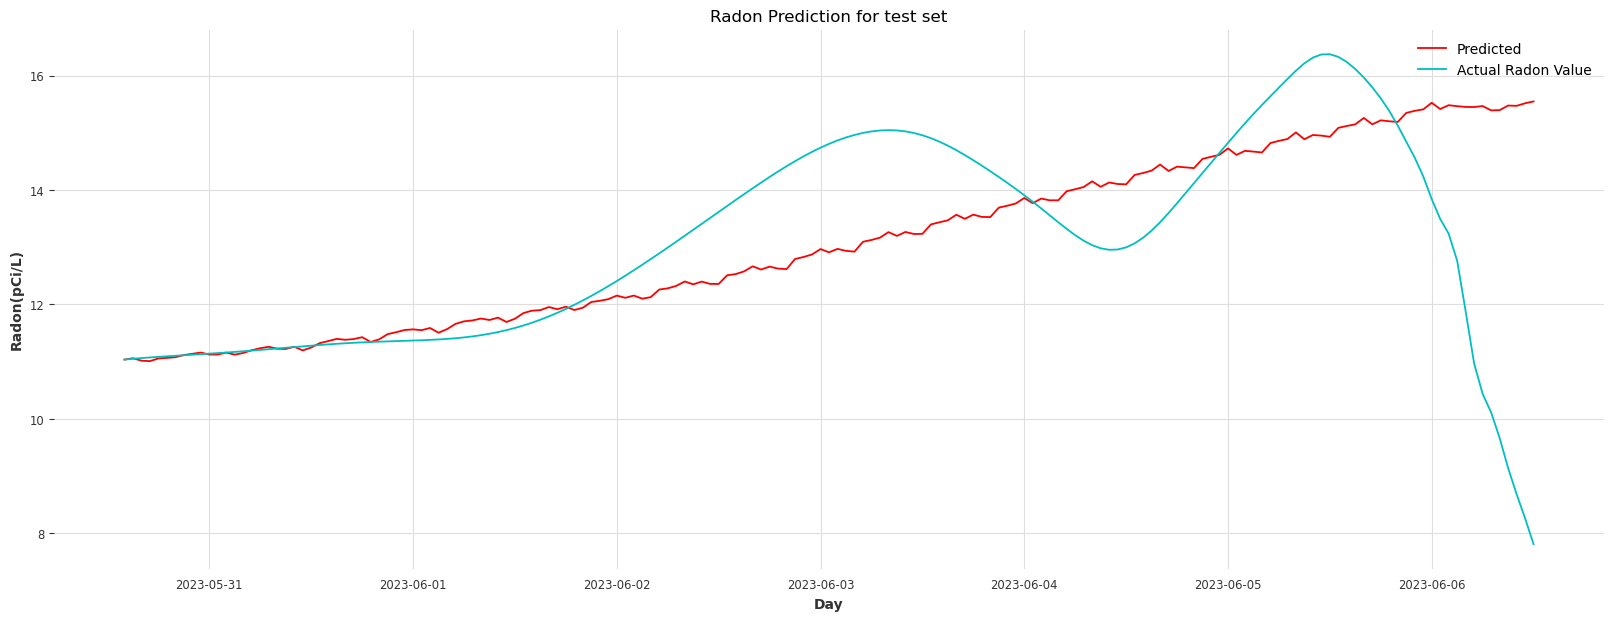

In [19]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [20]:
df = df_radon['13'].copy()

In [21]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [22]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [23]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [24]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [25]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [26]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [27]:
def set_seed(seed_value):
    import random
    import numpy as np
    import torch

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(seed_value, workers=True)

In [28]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nlinear_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NLinear",
        shared_weights=False,
        normalize=model_args['normalize'],
        const_init=model_args['const_init'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
               
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [29]:
def build_fit_nlinear_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1
    set_seed(42)
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "devices":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": True,
        }
  
   

    model = NLinearModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="DLinear",
        shared_weights=False,
        const_init=model_args['const_init'],
        normalize=model_args['normalize'],
        use_static_covariates=False,
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
      
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
               )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [30]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,168),#setting 168 is not a good option here as convolutions take time reducing this to 80
    "out_len":tune.randint(1,24),
    "normalize": tune.choice([True, False]),
    "const_init":tune.choice([True, False]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size":tune.choice([16,32,64,128,256]),
    
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nlinear_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="dlinear_tune_cov",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-11 08:31:46 (running for 00:00:00.14)
Memory usage on this node: 54.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 1/100 (1 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------|
| build_fit_nlinear_model_4ed01198 | RUNNING  | 172.31.10.87:2757799 |       50 |        22 

(build_fit_nlinear_model pid=2757799) Global seed set to 42
(build_fit_nlinear_model pid=2757799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2757799)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2757799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2757799)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2757799) Auto select gpus: [0]
(build_fit_nlinear_model pid=2757799) GPU available: 

== Status ==
Current time: 2023-07-11 08:31:56 (running for 00:00:09.76)
Memory usage on this node: 59.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------|
| build_fit_nlinear_model_4ed01198 | RUNNING  | 172.31.10.87:2757

(build_fit_nlinear_model pid=2758036) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2758036)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2758036) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2758036)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2758042) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecat

(build_fit_nlinear_model pid=2758036) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758036) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758036) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758036) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758036) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758036) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758036) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2758036) 
(build_fit_nlinear_model pid=2758036)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2758036) -----

(build_fit_nlinear_model pid=2758029) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2758029)   rank_zero_warn(
(build_fit_nlinear_model pid=2758029) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2758029)   rank_zero_warn(
(build_fit_nlinear_model pid=2758029) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:32:01 (running for 00:00:14.77)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+
| Trial name                       | status   | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |
|----------------------------------+----------+----------------------+----------+-----------+-------------+--------------+-------------+--------------|
| build_fit_nlinear_model_4ed01198 | RUNNING  | 172.31.10.87:2757

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 330.65it/s]


(build_fit_nlinear_model pid=2758042) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758042) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758042) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758042) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758042) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758042) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758042) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2758044) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758044) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.65it/s]


(build_fit_nlinear_model pid=2758040) Auto select gpus: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 264.88it/s]
== Status ==
Current time: 2023-07-11 08:32:17 (running for 00:00:31.27)
Memory usage on this node: 68.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   i

(build_fit_nlinear_model pid=2758040) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758040) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758040) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758040) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758040) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758040) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2759775) Global seed set to 42
(build_fit_nlinear_model pid=2759775) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningD

(build_fit_nlinear_model pid=2760241) Global seed set to 42
(build_fit_nlinear_model pid=2760241) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2760241)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2760241) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2760241)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:32:23 (running for 00:00:36.65)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2760241) Auto select gpus: [0]
(build_fit_nlinear_model pid=2760241) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2760241) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2760241) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2760241) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2760241) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2760241) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2760241) 
(build_fit_nlinear_model pid=2760241)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2760241) -----

== Status ==
Current time: 2023-07-11 08:32:28 (running for 00:00:41.65)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2758031) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758031) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758031) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758031) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758031) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758031) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758031) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2760568) Global seed set to 42
(build_fit_nlinear_model pid=2760568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:32:41 (running for 00:00:54.65)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2760568) Auto select gpus: [0]
(build_fit_nlinear_model pid=2760568) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2760568) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2760568) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2760568) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2760568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2760568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2760568) 
(build_fit_nlinear_model pid=2760568)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2760568) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.76it/s]


(build_fit_nlinear_model pid=2760821) Global seed set to 42
(build_fit_nlinear_model pid=2760821) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2760821)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2760821) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2760821)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:32:49 (running for 00:01:02.65)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2760821) Auto select gpus: [0]
(build_fit_nlinear_model pid=2760821) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2760821) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2760821) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2760821) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2760821) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2760821) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2760821) 
(build_fit_nlinear_model pid=2760821)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2760821) -----

== Status ==
Current time: 2023-07-11 08:32:54 (running for 00:01:07.66)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 322.81it/s]


(build_fit_nlinear_model pid=2759773) Auto select gpus: [0]
(build_fit_nlinear_model pid=2759773) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2759773) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2759773) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2759773) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2759773) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2759773) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2761101) Global seed set to 42
(build_fit_nlinear_model pid=2761101) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:33:13 (running for 00:01:26.65)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2761101) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761101) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2761101) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2761101) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2761101) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2761101) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2761101) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2761101) 
(build_fit_nlinear_model pid=2761101)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2761101) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 350.93it/s]


(build_fit_nlinear_model pid=2758036) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758036) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758036) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758036) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758036) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758036) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758036) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2761357) Global seed set to 42
(build_fit_nlinear_model pid=2761357) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:33:23 (running for 00:01:36.65)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2761357) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761357) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2761357) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2761357) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2761357) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2761357) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2761357) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2761357) 
(build_fit_nlinear_model pid=2761357)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2761357) -----

== Status ==
Current time: 2023-07-11 08:33:28 (running for 00:01:41.66)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2760568) Auto select gpus: [0]
(build_fit_nlinear_model pid=2760568) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2760568) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2760568) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2760568) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2760568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2760568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 267.73it/s]
== Status ==
Current time: 2023-07-11 08:33:44 (running for 00:01:57.64)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 16/100 (8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   o

(build_fit_nlinear_model pid=2761690) Global seed set to 42
(build_fit_nlinear_model pid=2761690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2761690)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2761690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2761690)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2761690) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761690) GPU available: 

== Status ==
Current time: 2023-07-11 08:33:53 (running for 00:02:07.28)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

== Status ==
Current time: 2023-07-11 08:34:03 (running for 00:02:17.29)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2759775) Auto select gpus: [0]
(build_fit_nlinear_model pid=2759775) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2759775) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2759775) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2759775) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2759775) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2759775) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 323.24it/s]
== Status ==
Current time: 2023-07-11 08:34:14 (running for 00:02:27.65)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 17/100 (8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   o

(build_fit_nlinear_model pid=2762028) Global seed set to 42
(build_fit_nlinear_model pid=2762028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2762028)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2762028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2762028)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.33it/s]


(build_fit_nlinear_model pid=2761690) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761690) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2761690) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2761690) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2761690) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2761690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2761690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2762028) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762028) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

== Status ==
Current time: 2023-07-11 08:34:19 (running for 00:02:33.41)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_s

(build_fit_nlinear_model pid=2762028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2762028)   rank_zero_warn(
(build_fit_nlinear_model pid=2762028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2762028)   rank_zero_warn(
(build_fit_nlinear_model pid=2762028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:34:25 (running for 00:02:38.67)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762312) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762312) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762312) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762312) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762312) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2762312) 
(build_fit_nlinear_model pid=2762312)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2762312) -----

== Status ==
Current time: 2023-07-11 08:34:30 (running for 00:02:43.67)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 19/100 (1 PENDING, 8 RUNNING, 10 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762028) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762028) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762028) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762028) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762028) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762028) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762028) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.15it/s]


(build_fit_nlinear_model pid=2762586) Global seed set to 42
(build_fit_nlinear_model pid=2762586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2762586)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2762586) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2762586)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:34:43 (running for 00:02:56.68)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762586) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762586) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762586) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762586) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762586) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2762586) 
(build_fit_nlinear_model pid=2762586)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2762586) -----

== Status ==
Current time: 2023-07-11 08:34:48 (running for 00:03:01.69)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.39it/s]


(build_fit_nlinear_model pid=2760821) Auto select gpus: [0]
(build_fit_nlinear_model pid=2760821) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2760821) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2760821) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2760821) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2760821) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2760821) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2762863) Global seed set to 42
(build_fit_nlinear_model pid=2762863) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:35:03 (running for 00:03:16.67)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762863) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762863) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762863) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762863) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762863) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762863) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762863) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2762863) 
(build_fit_nlinear_model pid=2762863)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2762863) -----

== Status ==
Current time: 2023-07-11 08:35:08 (running for 00:03:21.68)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:35:18 (running for 00:03:31.70)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:35:28 (running for 00:03:41.71)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:35:38 (running for 00:03:51.73)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:35:48 (running for 00:04:01.75)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:35:58 (running for 00:04:11.76)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:08 (running for 00:04:21.78)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:18 (running for 00:04:31.79)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:28 (running for 00:04:41.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:38 (running for 00:04:51.81)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:48 (running for 00:05:01.83)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:36:58 (running for 00:05:11.84)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762312) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762312) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762312) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762312) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762312) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762312) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762312) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 258.56it/s]


(build_fit_nlinear_model pid=2763567) Global seed set to 42
(build_fit_nlinear_model pid=2763567) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2763567)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2763567) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2763567)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:37:11 (running for 00:05:24.69)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2763567) Auto select gpus: [0]
(build_fit_nlinear_model pid=2763567) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2763567) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2763567) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2763567) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2763567) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2763567) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2763567) 
(build_fit_nlinear_model pid=2763567)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2763567) -----

== Status ==
Current time: 2023-07-11 08:37:16 (running for 00:05:29.70)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:37:26 (running for 00:05:39.72)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:37:36 (running for 00:05:49.73)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:37:46 (running for 00:05:59.74)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2761357) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761357) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2761357) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2761357) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2761357) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2761357) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2761357) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2763919) Global seed set to 42
(build_fit_nlinear_model pid=2763919) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:37:53 (running for 00:06:06.69)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2763919) Auto select gpus: [0]
(build_fit_nlinear_model pid=2763919) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2763919) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2763919) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2763919) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2763919) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2763919) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2763919) 
(build_fit_nlinear_model pid=2763919)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2763919) -----

== Status ==
Current time: 2023-07-11 08:37:58 (running for 00:06:11.70)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:38:08 (running for 00:06:21.71)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2758033) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758033) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758033) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758033) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758033) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758033) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758033) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 346.04it/s]


(build_fit_nlinear_model pid=2761101) Auto select gpus: [0]
(build_fit_nlinear_model pid=2761101) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2761101) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2761101) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2761101) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2761101) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2761101) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 258.27it/s]


(build_fit_nlinear_model pid=2764201) Global seed set to 42
(build_fit_nlinear_model pid=2764201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2764201)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2764201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2764201)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2764362) Global seed set to 42
(build_fit_nlinear_model pid=2764362) /home/ubuntu/an

== Status ==
Current time: 2023-07-11 08:38:16 (running for 00:06:29.69)
Memory usage on this node: 69.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2764201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2764201)   rank_zero_warn(
(build_fit_nlinear_model pid=2764201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2764201)   rank_zero_warn(
(build_fit_nlinear_model pid=2764362) Auto select gpus: [0]
(build_fit_nlinear_model pid=2764201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger

== Status ==
Current time: 2023-07-11 08:38:21 (running for 00:06:34.70)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a54a5bac with q_smape=24.158818047296123 and parameters={'in_len': 39, 'out_len': 19, 'normalize': True, 'const_init': True, 'lr': 0.005277896667452298, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2764362) Auto select gpus: [0]
(build_fit_nlinear_model pid=2764362) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2764362) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2764362) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2764362) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2764362) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2764362) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 289.06it/s]


(build_fit_nlinear_model pid=2764201) Auto select gpus: [0]
(build_fit_nlinear_model pid=2764201) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2764201) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2764201) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2764201) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2764201) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2764201) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:38:33 (running for 00:06:47.23)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2764757) Global seed set to 42
(build_fit_nlinear_model pid=2764757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2764757)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2764757) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2764757)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2764757) Auto select gpus: [0]
(build_fit_nlinear_model pid=2764757) GPU available: 

== Status ==
Current time: 2023-07-11 08:38:39 (running for 00:06:52.70)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2765001) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765001) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765001) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765001) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765001) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2765001) 
(build_fit_nlinear_model pid=2765001)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2765001) -----

== Status ==
Current time: 2023-07-11 08:38:44 (running for 00:06:57.71)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:38:54 (running for 00:07:07.73)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2764757) Auto select gpus: [0]
(build_fit_nlinear_model pid=2764757) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2764757) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2764757) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2764757) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2764757) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2764757) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2765281) Global seed set to 42
(build_fit_nlinear_model pid=2765281) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:39:01 (running for 00:07:14.70)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2765281) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765281) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765281) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765281) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765281) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765281) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765281) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2765281) 
(build_fit_nlinear_model pid=2765281)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2765281) -----

== Status ==
Current time: 2023-07-11 08:39:06 (running for 00:07:19.71)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2757799) Auto select gpus: [0]
(build_fit_nlinear_model pid=2757799) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2757799) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2757799) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2757799) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2757799) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2757799) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 360.52it/s]


(build_fit_nlinear_model pid=2758029) Auto select gpus: [0]
(build_fit_nlinear_model pid=2758029) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2758029) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2758029) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2758029) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2758029) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2758029) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 307.19it/s]


(build_fit_nlinear_model pid=2765281) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765281) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765281) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765281) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765281) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765281) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765281) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:39:12 (running for 00:07:25.60)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2765582) Global seed set to 42
(build_fit_nlinear_model pid=2765582) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2765582)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2765582) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2765582)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2765582) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765582) GPU available: 

== Status ==
Current time: 2023-07-11 08:39:18 (running for 00:07:31.74)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2765831) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765831) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765831) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765831) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765831) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765831) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765831) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2765831) 
(build_fit_nlinear_model pid=2765831)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2765831) -----

== Status ==
Current time: 2023-07-11 08:39:23 (running for 00:07:36.74)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:39:33 (running for 00:07:46.76)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2765831) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765831) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765831) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765831) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765831) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765831) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765831) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2765582) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765582) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 301.92it/s]
== Status ==
Current time: 2023-07-11 08:39:38 (running for 00:07:51.92)
Memory usage on this node: 69.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2766432) Global seed set to 42
(build_fit_nlinear_model pid=2766432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2766432)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2766432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2766432)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2766432) Auto select gpus: [0]
(build_fit_nlinear_model pid=2766432) GPU available: 

== Status ==
Current time: 2023-07-11 08:39:47 (running for 00:08:00.71)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2766674) Auto select gpus: [0]
(build_fit_nlinear_model pid=2766674) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2766674) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2766674) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2766674) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2766674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2766674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2766674) 
(build_fit_nlinear_model pid=2766674)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2766674) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.29it/s]


(build_fit_nlinear_model pid=2765001) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765001) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765001) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765001) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765001) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765001) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765001) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 290.00it/s]


(build_fit_nlinear_model pid=2765829) Auto select gpus: [0]
(build_fit_nlinear_model pid=2765829) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2765829) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2765829) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2765829) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2765829) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2765829) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2766930) Global seed set to 42
(build_fit_nlinear_model pid=2766930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:39:56 (running for 00:08:09.71)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2766930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2766930)   rank_zero_warn(
(build_fit_nlinear_model pid=2766930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2766930)   rank_zero_warn(
(build_fit_nlinear_model pid=2766930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:40:01 (running for 00:08:14.72)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:40:11 (running for 00:08:24.73)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:40:21 (running for 00:08:34.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:40:31 (running for 00:08:44.76)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:40:41 (running for 00:08:54.78)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2766674) Auto select gpus: [0]
(build_fit_nlinear_model pid=2766674) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2766674) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2766674) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2766674) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2766674) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2766674) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.43it/s]


(build_fit_nlinear_model pid=2767557) Global seed set to 42
(build_fit_nlinear_model pid=2767557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2767557)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2767557) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2767557)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:40:50 (running for 00:09:03.71)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2767557) Auto select gpus: [0]
(build_fit_nlinear_model pid=2767557) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2767557) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2767557) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2767557) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2767557) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2767557) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2767557) 
(build_fit_nlinear_model pid=2767557)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2767557) -----

== Status ==
Current time: 2023-07-11 08:40:55 (running for 00:09:08.73)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.40it/s]


(build_fit_nlinear_model pid=2766432) Auto select gpus: [0]
(build_fit_nlinear_model pid=2766432) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2766432) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2766432) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2766432) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2766432) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2766432) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2767832) Global seed set to 42
(build_fit_nlinear_model pid=2767832) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:41:10 (running for 00:09:23.73)
Memory usage on this node: 70.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2767832) Auto select gpus: [0]
(build_fit_nlinear_model pid=2767832) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2767832) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2767832) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2767832) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2767832) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2767832) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2767832) 
(build_fit_nlinear_model pid=2767832)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2767832) -----

== Status ==
Current time: 2023-07-11 08:41:15 (running for 00:09:28.74)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2766930) Auto select gpus: [0]
(build_fit_nlinear_model pid=2766930) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2766930) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2766930) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2766930) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2766930) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2766930) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.20it/s]


(build_fit_nlinear_model pid=2768147) Global seed set to 42
(build_fit_nlinear_model pid=2768147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2768147)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2768147) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2768147)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:41:28 (running for 00:09:41.72)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2768147) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768147) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2768147) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2768147) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2768147) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2768147) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2768147) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2768147) 
(build_fit_nlinear_model pid=2768147)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2768147) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.35it/s]


(build_fit_nlinear_model pid=2768396) Global seed set to 42
(build_fit_nlinear_model pid=2768396) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2768396)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2768396) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2768396)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:41:36 (running for 00:09:49.73)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2768396) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768396) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2768396) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2768396) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2768396) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2768396) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2768396) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2768396) 
(build_fit_nlinear_model pid=2768396)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2768396) -----

== Status ==
Current time: 2023-07-11 08:41:41 (running for 00:09:54.74)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:41:51 (running for 00:10:04.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:42:01 (running for 00:10:14.77)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2768147) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768147) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2768147) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2768147) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2768147) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2768147) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2768147) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.27it/s]


(build_fit_nlinear_model pid=2767832) Auto select gpus: [0]
(build_fit_nlinear_model pid=2767832) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2767832) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2767832) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2767832) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2767832) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2767832) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:42:07 (running for 00:10:20.71)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 39/100 (8 RUNNING, 31 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2768829) Global seed set to 42
(build_fit_nlinear_model pid=2768829) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2768829)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2768829) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2768829)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2768829) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768829) GPU available: 

== Status ==
Current time: 2023-07-11 08:42:17 (running for 00:10:30.73)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2769072) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769072) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769072) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769072) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769072) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769072) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769072) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2769072) 
(build_fit_nlinear_model pid=2769072)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2769072) -----

== Status ==
Current time: 2023-07-11 08:42:22 (running for 00:10:35.74)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:42:32 (running for 00:10:45.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:42:42 (running for 00:10:55.77)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:42:52 (running for 00:11:05.79)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:43:02 (running for 00:11:15.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2768829) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768829) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2768829) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2768829) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2768829) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2768829) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2768829) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.77it/s]


(build_fit_nlinear_model pid=2769467) Global seed set to 42
(build_fit_nlinear_model pid=2769467) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2769467)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2769467) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2769467)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:43:11 (running for 00:11:24.74)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2769467) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769467) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769467) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769467) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769467) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769467) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2769467) 
(build_fit_nlinear_model pid=2769467)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2769467) -----

== Status ==
Current time: 2023-07-11 08:43:16 (running for 00:11:29.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 229.70it/s]


(build_fit_nlinear_model pid=2763567) Auto select gpus: [0]
(build_fit_nlinear_model pid=2763567) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2763567) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2763567) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2763567) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2763567) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2763567) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2769786) Global seed set to 42
(build_fit_nlinear_model pid=2769786) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:43:31 (running for 00:11:44.74)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2769786) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769786) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769786) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769786) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769786) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769786) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769786) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2769786) 
(build_fit_nlinear_model pid=2769786)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2769786) -----

== Status ==
Current time: 2023-07-11 08:43:36 (running for 00:11:49.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.08it/s]


(build_fit_nlinear_model pid=2769072) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769072) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769072) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769072) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769072) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769072) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769072) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2770063) Global seed set to 42
(build_fit_nlinear_model pid=2770063) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:43:51 (running for 00:12:04.74)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2770063) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770063) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770063) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770063) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770063) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770063) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770063) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2770063) 
(build_fit_nlinear_model pid=2770063)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2770063) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 322.44it/s]


(build_fit_nlinear_model pid=2762586) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762586) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762586) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762586) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762586) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762586) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762586) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2770321) Global seed set to 42
(build_fit_nlinear_model pid=2770321) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:44:01 (running for 00:12:14.75)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2770321) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770321) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770321) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770321) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770321) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2770321) 
(build_fit_nlinear_model pid=2770321)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2770321) -----

== Status ==
Current time: 2023-07-11 08:44:06 (running for 00:12:19.76)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.92it/s]


(build_fit_nlinear_model pid=2769467) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769467) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769467) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769467) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769467) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769467) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2770632) Global seed set to 42
(build_fit_nlinear_model pid=2770632) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:44:17 (running for 00:12:30.75)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2770632) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770632) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770632) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770632) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770632) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770632) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770632) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2770632) 
(build_fit_nlinear_model pid=2770632)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2770632) -----

== Status ==
Current time: 2023-07-11 08:44:22 (running for 00:12:35.75)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:44:32 (running for 00:12:45.77)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2768396) Auto select gpus: [0]
(build_fit_nlinear_model pid=2768396) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2768396) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2768396) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2768396) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2768396) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2768396) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.80it/s]


(build_fit_nlinear_model pid=2770994) Global seed set to 42
(build_fit_nlinear_model pid=2770994) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2770994)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2770994) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2770994)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:44:39 (running for 00:12:52.75)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2770994) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770994) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770994) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770994) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770994) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770994) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770994) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2770994) 
(build_fit_nlinear_model pid=2770994)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2770994) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.38it/s]


(build_fit_nlinear_model pid=2767557) Auto select gpus: [0]
(build_fit_nlinear_model pid=2767557) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2767557) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2767557) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2767557) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2767557) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2767557) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.63it/s]


(build_fit_nlinear_model pid=2770063) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770063) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770063) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770063) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770063) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770063) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770063) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2771255) Global seed set to 42
(build_fit_nlinear_model pid=2771255) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:44:44 (running for 00:12:57.75)
Memory usage on this node: 67.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 48/100 (8 RUNNING, 40 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2771257) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2771257)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2771257) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2771257)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2771255) Auto select gpus: [0]
(build_fit_nlinear_model pid=2771255) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2771255

== Status ==
Current time: 2023-07-11 08:44:54 (running for 00:13:07.58)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2769786) Auto select gpus: [0]
(build_fit_nlinear_model pid=2769786) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2769786) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2769786) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2769786) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2769786) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2769786) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2771752) Global seed set to 42
(build_fit_nlinear_model pid=2771752) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:45:03 (running for 00:13:16.75)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2771752) Auto select gpus: [0]
(build_fit_nlinear_model pid=2771752) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2771752) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2771752) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2771752) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2771752) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2771752) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2771752) 
(build_fit_nlinear_model pid=2771752)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2771752) -----

== Status ==
Current time: 2023-07-11 08:45:08 (running for 00:13:21.76)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:45:18 (running for 00:13:31.78)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:45:28 (running for 00:13:41.79)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:45:38 (running for 00:13:51.81)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:45:48 (running for 00:14:01.82)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.84it/s]


(build_fit_nlinear_model pid=2771255) Auto select gpus: [0]
(build_fit_nlinear_model pid=2771255) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2771255) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2771255) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2771255) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2771255) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2771255) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2772152) Global seed set to 42
(build_fit_nlinear_model pid=2772152) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:46:03 (running for 00:14:16.76)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2772152) Auto select gpus: [0]
(build_fit_nlinear_model pid=2772152) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2772152) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2772152) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2772152) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2772152) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2772152) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2772152) 
(build_fit_nlinear_model pid=2772152)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2772152) -----

== Status ==
Current time: 2023-07-11 08:46:08 (running for 00:14:21.77)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:46:18 (running for 00:14:31.78)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:46:28 (running for 00:14:41.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:46:38 (running for 00:14:51.82)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:46:48 (running for 00:15:01.84)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:46:58 (running for 00:15:11.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:47:08 (running for 00:15:21.88)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 252.81it/s]


(build_fit_nlinear_model pid=2770321) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770321) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770321) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770321) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770321) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770321) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770321) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2772673) Global seed set to 42
(build_fit_nlinear_model pid=2772673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:47:23 (running for 00:15:36.77)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2772673) Auto select gpus: [0]
(build_fit_nlinear_model pid=2772673) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2772673) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2772673) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2772673) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2772673) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2772673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2772673) 
(build_fit_nlinear_model pid=2772673)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2772673) -----

== Status ==
Current time: 2023-07-11 08:47:28 (running for 00:15:41.79)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:47:38 (running for 00:15:51.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:47:48 (running for 00:16:01.82)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2772673) Auto select gpus: [0]
(build_fit_nlinear_model pid=2772673) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2772673) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2772673) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2772673) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2772673) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2772673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.59it/s]


(build_fit_nlinear_model pid=2773024) Global seed set to 42
(build_fit_nlinear_model pid=2773024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2773024)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2773024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2773024)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:47:59 (running for 00:16:12.78)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2773024) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773024) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773024) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773024) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773024) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773024) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773024) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2773024) 
(build_fit_nlinear_model pid=2773024)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2773024) -----

== Status ==
Current time: 2023-07-11 08:48:04 (running for 00:16:17.78)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2770994) Auto select gpus: [0]
(build_fit_nlinear_model pid=2770994) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2770994) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2770994) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2770994) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2770994) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2770994) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.92it/s]


(build_fit_nlinear_model pid=2773300) Global seed set to 42
(build_fit_nlinear_model pid=2773300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2773300)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2773300) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2773300)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:48:19 (running for 00:16:32.77)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2773300) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773300) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773300) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773300) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773300) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773300) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773300) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2773300) 
(build_fit_nlinear_model pid=2773300)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2773300) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 253.60it/s]


(build_fit_nlinear_model pid=2773596) Global seed set to 42
(build_fit_nlinear_model pid=2773596) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2773596)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2773596) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2773596)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:48:29 (running for 00:16:42.77)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2773596) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773596) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773596) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773596) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773596) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773596) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773596) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2773596) 
(build_fit_nlinear_model pid=2773596)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2773596) -----

== Status ==
Current time: 2023-07-11 08:48:34 (running for 00:16:47.79)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2771257) Auto select gpus: [0]
(build_fit_nlinear_model pid=2771257) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2771257) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2771257) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2771257) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2771257) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2771257) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.87it/s]


(build_fit_nlinear_model pid=2772152) Auto select gpus: [0]
(build_fit_nlinear_model pid=2772152) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2772152) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2772152) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2772152) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2772152) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2772152) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:48:40 (running for 00:16:53.76)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 55/100 (8 RUNNING, 47 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2773869) Global seed set to 42
(build_fit_nlinear_model pid=2773869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2773869)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2773869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2773869)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2773869) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773869) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.98it/s]


(build_fit_nlinear_model pid=2771752) Auto select gpus: [0]
(build_fit_nlinear_model pid=2771752) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2771752) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2771752) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2771752) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2771752) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2771752) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2773869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_

== Status ==
Current time: 2023-07-11 08:48:46 (running for 00:17:00.42)
Memory usage on this node: 69.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774112) Global seed set to 42
(build_fit_nlinear_model pid=2774112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2774112)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2774112) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2774112)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2774112) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774112) GPU available: 

== Status ==
Current time: 2023-07-11 08:48:55 (running for 00:17:08.79)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774356) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774356) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774356) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774356) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774356) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774356) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774356) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2774356) 
(build_fit_nlinear_model pid=2774356)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2774356) -----

== Status ==
Current time: 2023-07-11 08:49:00 (running for 00:17:13.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:49:10 (running for 00:17:23.82)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2773869) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773869) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773869) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773869) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773869) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773869) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773869) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.61it/s]


(build_fit_nlinear_model pid=2773024) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773024) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773024) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773024) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773024) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773024) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773024) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-11 08:49:24 (running for 00:17:38.37)
Memory usage on this node: 70.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774739) Global seed set to 42
(build_fit_nlinear_model pid=2774739) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2774739)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2774739) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2774739)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2774739) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774739) GPU available: 

== Status ==
Current time: 2023-07-11 08:49:30 (running for 00:17:43.80)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774982) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774982) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774982) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774982) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774982) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2774982) 
(build_fit_nlinear_model pid=2774982)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2774982) -----

== Status ==
Current time: 2023-07-11 08:49:35 (running for 00:17:48.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2762863) Auto select gpus: [0]
(build_fit_nlinear_model pid=2762863) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2762863) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2762863) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2762863) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2762863) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2762863) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:49:41 (running for 00:17:54.77)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 60/100 (8 RUNNING, 52 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2775296) Global seed set to 42
(build_fit_nlinear_model pid=2775296) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2775296)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775296) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2775296)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775296) Auto select gpus: [0]
(build_fit_nlinear_model pid=2775296) GPU available: 

== Status ==
Current time: 2023-07-11 08:49:50 (running for 00:18:04.38)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:50:00 (running for 00:18:14.40)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:50:10 (running for 00:18:24.42)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2763919) Auto select gpus: [0]
(build_fit_nlinear_model pid=2763919) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2763919) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2763919) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2763919) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2763919) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2763919) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.66it/s]


(build_fit_nlinear_model pid=2773596) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773596) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773596) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773596) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773596) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773596) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773596) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 08:50:17 (running for 00:18:30.95)
Memory usage on this node: 69.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2775601) Global seed set to 42
(build_fit_nlinear_model pid=2775601) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2775601)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775601) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2775601)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775601) Auto select gpus: [0]
(build_fit_nlinear_model pid=2775601) GPU available: 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2774356) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774356) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774356) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774356) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774356) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774356) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774356) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.32it/s]
== Status ==
Current time: 2023-07-11 08:50:24 (running for 00:18:38.32)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2775842) Global seed set to 42
(build_fit_nlinear_model pid=2775842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2775842)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2775842)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2775842) Auto select gpus: [0]
(build_fit_nlinear_model pid=2775842) GPU available: 

== Status ==
Current time: 2023-07-11 08:50:30 (running for 00:18:43.80)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2776090) Auto select gpus: [0]
(build_fit_nlinear_model pid=2776090) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2776090) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2776090) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2776090) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2776090) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2776090) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2776090) 
(build_fit_nlinear_model pid=2776090)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2776090) -----

== Status ==
Current time: 2023-07-11 08:50:35 (running for 00:18:48.81)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 64/100 (1 PENDING, 7 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smap

(build_fit_nlinear_model pid=2775296) Auto select gpus: [0]
(build_fit_nlinear_model pid=2775296) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2775296) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2775296) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2775296) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2775296) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2775296) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2776351) Global seed set to 42
(build_fit_nlinear_model pid=2776351) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:50:42 (running for 00:18:55.80)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2776351) Auto select gpus: [0]
(build_fit_nlinear_model pid=2776351) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2776351) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2776351) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2776351) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2776351) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2776351) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2776351) 
(build_fit_nlinear_model pid=2776351)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2776351) -----

== Status ==
Current time: 2023-07-11 08:50:47 (running for 00:19:00.80)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:50:57 (running for 00:19:10.83)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:51:07 (running for 00:19:20.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:51:17 (running for 00:19:30.87)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:51:27 (running for 00:19:40.89)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774982) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774982) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774982) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774982) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774982) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774982) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774982) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.69it/s]


(build_fit_nlinear_model pid=2776746) Global seed set to 42
(build_fit_nlinear_model pid=2776746) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2776746)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2776746) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2776746)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:51:40 (running for 00:19:53.80)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2776746) Auto select gpus: [0]
(build_fit_nlinear_model pid=2776746) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2776746) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2776746) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2776746) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2776746) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2776746) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2776746) 
(build_fit_nlinear_model pid=2776746)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2776746) -----

== Status ==
Current time: 2023-07-11 08:51:45 (running for 00:19:58.81)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:51:55 (running for 00:20:08.84)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:52:05 (running for 00:20:18.86)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2774739) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774739) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774739) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774739) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774739) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774739) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774739) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2777172) Global seed set to 42
(build_fit_nlinear_model pid=2777172) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:52:14 (running for 00:20:27.80)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2777172) Auto select gpus: [0]
(build_fit_nlinear_model pid=2777172) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2777172) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2777172) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2777172) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2777172) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2777172) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2777172) 
(build_fit_nlinear_model pid=2777172)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2777172) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.55it/s]


(build_fit_nlinear_model pid=2777424) Global seed set to 42
(build_fit_nlinear_model pid=2777424) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2777424)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2777424) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2777424)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:52:22 (running for 00:20:35.81)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2777424) Auto select gpus: [0]
(build_fit_nlinear_model pid=2777424) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2777424) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2777424) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2777424) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2777424) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2777424) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2777424) 
(build_fit_nlinear_model pid=2777424)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2777424) -----

== Status ==
Current time: 2023-07-11 08:52:27 (running for 00:20:40.83)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:52:37 (running for 00:20:50.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 68/100 (1 PENDING, 8 RUNNING, 59 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2777424) Auto select gpus: [0]
(build_fit_nlinear_model pid=2777424) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2777424) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2777424) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2777424) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2777424) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2777424) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.43it/s]
== Status ==
Current time: 2023-07-11 08:52:45 (running for 00:20:59.30)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2774112) Auto select gpus: [0]
(build_fit_nlinear_model pid=2774112) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2774112) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2774112) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2774112) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2774112) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2774112) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2777753) Global seed set to 42
(build_fit_nlinear_model pid=2777753) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.97it/s]


(build_fit_nlinear_model pid=2777753) Auto select gpus: [0]
(build_fit_nlinear_model pid=2777753) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2777753) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2777753) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2777753) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2777753) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2777753) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2777753) 
(build_fit_nlinear_model pid=2777753)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2777753) -----

== Status ==
Current time: 2023-07-11 08:52:52 (running for 00:21:05.82)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2778000) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2778000)   rank_zero_warn(
(build_fit_nlinear_model pid=2778000) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2778000)   rank_zero_warn(
(build_fit_nlinear_model pid=2778000) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:52:57 (running for 00:21:10.83)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:53:07 (running for 00:21:20.85)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2773300) Auto select gpus: [0]
(build_fit_nlinear_model pid=2773300) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2773300) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2773300) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2773300) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2773300) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2773300) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2778516) Global seed set to 42
(build_fit_nlinear_model pid=2778516) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:53:14 (running for 00:21:27.83)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2778516) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778516) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778516) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778516) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778516) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778516) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778516) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2778516) 
(build_fit_nlinear_model pid=2778516)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2778516) -----

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2776351) Auto select gpus: [0]
(build_fit_nlinear_model pid=2776351) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2776351) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2776351) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2776351) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2776351) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2776351) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s]


(build_fit_nlinear_model pid=2778768) Global seed set to 42
(build_fit_nlinear_model pid=2778768) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2778768)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2778768) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2778768)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:53:22 (running for 00:21:35.81)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2778768) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778768) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778768) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778768) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778768) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778768) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778768) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2778768) 
(build_fit_nlinear_model pid=2778768)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2778768) -----

== Status ==
Current time: 2023-07-11 08:53:27 (running for 00:21:40.83)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2777753) Auto select gpus: [0]
(build_fit_nlinear_model pid=2777753) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2777753) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2777753) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2777753) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2777753) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2777753) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.59it/s]


(build_fit_nlinear_model pid=2778155) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778155) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778155) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778155) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778155) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778155) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778155) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.22it/s]


(build_fit_nlinear_model pid=2779082) Global seed set to 42
(build_fit_nlinear_model pid=2779082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2779082)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2779082) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2779082)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.80it/s]


(build_fit_nlinear_model pid=2776746) Auto select gpus: [0]
(build_fit_nlinear_model pid=2776746) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2776746) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2776746) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2776746) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2776746) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2776746) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2779082) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779082) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

== Status ==
Current time: 2023-07-11 08:53:38 (running for 00:21:52.06)
Memory usage on this node: 68.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f8c50c3a with q_smape=20.614232948897232 and parameters={'in_len': 12, 'out_len': 23, 'normalize': True, 'const_init': True, 'lr': 0.011139772291419799, 'batch_size': 128}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2779247) Global seed set to 42
(build_fit_nlinear_model pid=2779247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2779247)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2779247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2779247)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2779247) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779247) GPU available: 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.86it/s]


(build_fit_nlinear_model pid=2779247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2779247)   rank_zero_warn(
(build_fit_nlinear_model pid=2779247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2779247)   rank_zero_warn(
(build_fit_nlinear_model pid=2779247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.56it/s]


(build_fit_nlinear_model pid=2779564) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779564) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2779564) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2779564) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2779564) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2779564) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2779564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2779564) 
(build_fit_nlinear_model pid=2779564)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2779564) -----

== Status ==
Current time: 2023-07-11 08:53:47 (running for 00:22:00.54)
Memory usage on this node: 68.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2779564) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2779564)   rank_zero_warn(
(build_fit_nlinear_model pid=2779564) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2779564)   rank_zero_warn(
(build_fit_nlinear_model pid=2779564) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:53:53 (running for 00:22:06.83)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2780050) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780050) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780050) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780050) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780050) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780050) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780050) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2780050) 
(build_fit_nlinear_model pid=2780050)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2780050) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.62it/s]


(build_fit_nlinear_model pid=2779082) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779082) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2779082) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2779082) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2779082) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2779082) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2779082) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.91it/s]


(build_fit_nlinear_model pid=2778000) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778000) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778000) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778000) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778000) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778000) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778000) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2780317) Global seed set to 42
(build_fit_nlinear_model pid=2780315) Global seed set to 42
(build_fit_nlinear_model pid=2780315) /home/ub

== Status ==
Current time: 2023-07-11 08:54:03 (running for 00:22:16.86)
Memory usage on this node: 68.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2780317) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780317) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780317) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780317) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780317) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780317) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780317) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2780317) 
(build_fit_nlinear_model pid=2780317)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2780317) -----

== Status ==
Current time: 2023-07-11 08:54:08 (running for 00:22:21.87)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:54:18 (running for 00:22:31.90)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2779734) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779734) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2779734) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2779734) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2779734) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2779734) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2779734) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2779247) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779247) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.43it/s]
== Status ==
Current time: 2023-07-11 08:54:24 (running for 00:22:37.81)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 80/100 (8 RUNNING, 72 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   

(build_fit_nlinear_model pid=2780914) Global seed set to 42
(build_fit_nlinear_model pid=2780914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2780914)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2780914) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2780914)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2780914) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780914) GPU available: 

== Status ==
Current time: 2023-07-11 08:54:34 (running for 00:22:47.83)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2781156) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781156) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781156) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781156) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781156) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781156) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781156) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2781156) 
(build_fit_nlinear_model pid=2781156)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2781156) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.67it/s]


(build_fit_nlinear_model pid=2778516) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778516) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778516) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778516) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778516) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778516) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778516) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 233.59it/s]


(build_fit_nlinear_model pid=2778768) Auto select gpus: [0]
(build_fit_nlinear_model pid=2778768) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2778768) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2778768) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2778768) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2778768) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2778768) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 08:54:40 (running for 00:22:54.28)
Memory usage on this node: 69.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2781457) Global seed set to 42
(build_fit_nlinear_model pid=2781457) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2781457)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2781457) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2781457)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2781457) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781457) GPU available: 

== Status ==
Current time: 2023-07-11 08:54:49 (running for 00:23:02.84)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2781698) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781698) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781698) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781698) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781698) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781698) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781698) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2781698) 
(build_fit_nlinear_model pid=2781698)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2781698) -----

== Status ==
Current time: 2023-07-11 08:54:54 (running for 00:23:07.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2781698) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781698) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781698) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781698) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781698) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781698) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781698) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.06it/s]


(build_fit_nlinear_model pid=2781974) Global seed set to 42
(build_fit_nlinear_model pid=2781974) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2781974)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2781974) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2781974)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 08:55:07 (running for 00:23:20.83)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2781974) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781974) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781974) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781974) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781974) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781974) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781974) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2781974) 
(build_fit_nlinear_model pid=2781974)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2781974) -----

== Status ==
Current time: 2023-07-11 08:55:12 (running for 00:23:25.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:55:22 (running for 00:23:35.88)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:55:32 (running for 00:23:45.90)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:55:42 (running for 00:23:55.92)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:55:52 (running for 00:24:05.94)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.05it/s]


(build_fit_nlinear_model pid=2780050) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780050) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780050) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780050) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780050) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780050) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780050) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2782366) Global seed set to 42
(build_fit_nlinear_model pid=2782366) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:56:05 (running for 00:24:18.85)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2782366) Auto select gpus: [0]
(build_fit_nlinear_model pid=2782366) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2782366) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2782366) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2782366) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2782366) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2782366) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2782366) 
(build_fit_nlinear_model pid=2782366)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2782366) -----

== Status ==
Current time: 2023-07-11 08:56:10 (running for 00:24:23.85)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:56:20 (running for 00:24:33.89)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:56:30 (running for 00:24:43.91)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:56:40 (running for 00:24:53.93)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:56:50 (running for 00:25:03.95)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.79it/s]


(build_fit_nlinear_model pid=2780315) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780315) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780315) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780315) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780315) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780315) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780315) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.98it/s]


(build_fit_nlinear_model pid=2781457) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781457) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781457) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781457) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781457) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781457) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781457) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2782763) Global seed set to 42
(build_fit_nlinear_model pid=2782763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:57:04 (running for 00:25:17.84)
Memory usage on this node: 69.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2782763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2782763)   rank_zero_warn(
(build_fit_nlinear_model pid=2782763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2782763)   rank_zero_warn(
(build_fit_nlinear_model pid=2782763) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

== Status ==
Current time: 2023-07-11 08:57:09 (running for 00:25:22.86)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:57:19 (running for 00:25:32.88)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2782925) Auto select gpus: [0]
(build_fit_nlinear_model pid=2782925) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2782925) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2782925) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2782925) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2782925) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2782925) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-11 08:57:25 (running for 00:25:38.83)
Memory usage on this node: 69.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 88/100 (8 RUNNING, 80 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_

(build_fit_nlinear_model pid=2783371) Global seed set to 42
(build_fit_nlinear_model pid=2783371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2783371)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2783371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2783371)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2783371) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783371) GPU available: 

== Status ==
Current time: 2023-07-11 08:57:35 (running for 00:25:48.56)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:57:45 (running for 00:25:58.59)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2780914) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780914) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780914) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780914) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780914) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780914) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780914) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2783695) Global seed set to 42
(build_fit_nlinear_model pid=2783695) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:57:52 (running for 00:26:05.85)
Memory usage on this node: 70.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2783695) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783695) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2783695) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2783695) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2783695) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2783695) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2783695) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2783695) 
(build_fit_nlinear_model pid=2783695)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2783695) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.09it/s]


(build_fit_nlinear_model pid=2779564) Auto select gpus: [0]
(build_fit_nlinear_model pid=2779564) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2779564) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2779564) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2779564) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2779564) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2779564) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2783954) Global seed set to 42
(build_fit_nlinear_model pid=2783954) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:58:02 (running for 00:26:15.85)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2783954) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783954) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2783954) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2783954) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2783954) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2783954) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2783954) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2783954) 
(build_fit_nlinear_model pid=2783954)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2783954) -----

== Status ==
Current time: 2023-07-11 08:58:07 (running for 00:26:20.87)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:58:17 (running for 00:26:30.89)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:58:27 (running for 00:26:40.92)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2783695) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783695) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2783695) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2783695) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2783695) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2783695) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2783695) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2784301) Global seed set to 42
(build_fit_nlinear_model pid=2784301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 08:58:36 (running for 00:26:49.86)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2784301) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784301) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2784301) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2784301) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2784301) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2784301) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2784301) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nlinear_model pid=2784301) 
(build_fit_nlinear_model pid=2784301)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2784301) -----

== Status ==
Current time: 2023-07-11 08:58:41 (running for 00:26:54.88)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:58:51 (running for 00:27:04.90)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:59:01 (running for 00:27:14.92)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:59:11 (running for 00:27:24.95)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:59:21 (running for 00:27:34.97)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.17it/s]


(build_fit_nlinear_model pid=2784301) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784301) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2784301) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2784301) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2784301) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2784301) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2784301) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nlinear_model pid=2781974) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781974) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781974) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781974) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781974) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781974) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781974) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.03it/s]
== Status ==
Current time: 2023-07-11 08:59:33 (running for 00:27:47.20)
Memory usage on this node: 69.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   

(build_fit_nlinear_model pid=2784734) Global seed set to 42
(build_fit_nlinear_model pid=2784734) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2784734)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2784734) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2784734)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2784734) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784734) GPU available: 

== Status ==
Current time: 2023-07-11 08:59:39 (running for 00:27:52.86)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2784978) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784978) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2784978) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2784978) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2784978) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2784978) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2784978) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2784978) 
(build_fit_nlinear_model pid=2784978)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2784978) -----

== Status ==
Current time: 2023-07-11 08:59:44 (running for 00:27:57.88)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 08:59:54 (running for 00:28:07.90)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:00:04 (running for 00:28:17.92)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:00:14 (running for 00:28:27.95)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:00:24 (running for 00:28:37.97)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2783371) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783371) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2783371) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2783371) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2783371) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2783371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2783371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.16it/s]


(build_fit_nlinear_model pid=2785326) Global seed set to 42
(build_fit_nlinear_model pid=2785326) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2785326)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2785326) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2785326)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 09:00:33 (running for 00:28:46.87)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2785326) Auto select gpus: [0]
(build_fit_nlinear_model pid=2785326) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2785326) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2785326) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2785326) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2785326) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2785326) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nlinear_model pid=2785326) 
(build_fit_nlinear_model pid=2785326)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2785326) -----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.58it/s]


(build_fit_nlinear_model pid=2782366) Auto select gpus: [0]
(build_fit_nlinear_model pid=2782366) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2782366) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2782366) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2782366) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2782366) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2782366) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2785581) Global seed set to 42
(build_fit_nlinear_model pid=2785581) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 09:00:43 (running for 00:28:56.88)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2785581) Auto select gpus: [0]
(build_fit_nlinear_model pid=2785581) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2785581) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2785581) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2785581) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2785581) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2785581) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2785581) 
(build_fit_nlinear_model pid=2785581)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2785581) -----

== Status ==
Current time: 2023-07-11 09:00:48 (running for 00:29:01.90)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:00:58 (running for 00:29:11.93)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:01:08 (running for 00:29:21.95)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:01:18 (running for 00:29:31.98)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:01:28 (running for 00:29:42.00)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.53it/s]


(build_fit_nlinear_model pid=2784978) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784978) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2784978) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2784978) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2784978) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2784978) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2784978) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2786021) Global seed set to 42
(build_fit_nlinear_model pid=2786021) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning

== Status ==
Current time: 2023-07-11 09:01:41 (running for 00:29:54.90)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2786021) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786021) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786021) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786021) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786021) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786021) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786021) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nlinear_model pid=2786021) 
(build_fit_nlinear_model pid=2786021)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2786021) -----

== Status ==
Current time: 2023-07-11 09:01:46 (running for 00:29:59.91)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:01:56 (running for 00:30:09.93)
Memory usage on this node: 71.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2785326) Auto select gpus: [0]
(build_fit_nlinear_model pid=2785326) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2785326) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2785326) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2785326) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2785326) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2785326) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.09it/s]


(build_fit_nlinear_model pid=2785581) Auto select gpus: [0]
(build_fit_nlinear_model pid=2785581) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2785581) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2785581) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2785581) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2785581) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2785581) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.55it/s]


(build_fit_nlinear_model pid=2786349) Global seed set to 42
(build_fit_nlinear_model pid=2786349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2786349)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2786349) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2786349)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2786349) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786349) GPU available: 

== Status ==
Current time: 2023-07-11 09:02:11 (running for 00:30:24.89)
Memory usage on this node: 70.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2786560) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786560) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786560) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786560) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786560) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786560) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786560) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2786560) 
(build_fit_nlinear_model pid=2786560)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2786560) -----

== Status ==
Current time: 2023-07-11 09:02:16 (running for 00:30:29.91)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:02:26 (running for 00:30:39.94)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

== Status ==
Current time: 2023-07-11 09:02:36 (running for 00:30:49.96)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_

(build_fit_nlinear_model pid=2783954) Auto select gpus: [0]
(build_fit_nlinear_model pid=2783954) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2783954) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2783954) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2783954) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2783954) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2783954) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.50it/s]


(build_fit_nlinear_model pid=2786989) Global seed set to 42
(build_fit_nlinear_model pid=2786989) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2786989)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2786989) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2786989)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-11 09:02:45 (running for 00:30:58.89)
Memory usage on this node: 70.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2786989) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786989) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786989) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786989) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786989) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786989) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786989) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nlinear_model pid=2786989) 
(build_fit_nlinear_model pid=2786989)   | Name          | Type             | Params
(build_fit_nlinear_model pid=2786989) -----

== Status ==
Current time: 2023-07-11 09:02:50 (running for 00:31:03.91)
Memory usage on this node: 71.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch

(build_fit_nlinear_model pid=2786021) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786021) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786021) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786021) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786021) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786021) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786021) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.28it/s]


(build_fit_nlinear_model pid=2786560) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786560) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786560) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786560) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786560) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786560) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786560) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.23it/s]


(build_fit_nlinear_model pid=2787261) Global seed set to 42
(build_fit_nlinear_model pid=2787261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nlinear_model pid=2787261)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2787261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nlinear_model pid=2787261)   rank_zero_deprecation(
(build_fit_nlinear_model pid=2787261) Auto select gpus: [0]
(build_fit_nlinear_model pid=2787261) GPU available: 

== Status ==
Current time: 2023-07-11 09:03:04 (running for 00:31:17.58)
Memory usage on this node: 68.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

(build_fit_nlinear_model pid=2787261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2787261)   rank_zero_warn(
(build_fit_nlinear_model pid=2787261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nlinear_model pid=2787261)   rank_zero_warn(
(build_fit_nlinear_model pid=2787261) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.79it/s]


(build_fit_nlinear_model pid=2784734) Auto select gpus: [0]
(build_fit_nlinear_model pid=2784734) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2784734) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2784734) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2784734) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2784734) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2784734) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 09:03:10 (running for 00:31:24.07)
Memory usage on this node: 67.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:03:20 (running for 00:31:34.10)
Memory usage on this node: 67.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:03:30 (running for 00:31:44.12)
Memory usage on this node: 67.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

(build_fit_nlinear_model pid=2786349) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786349) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786349) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786349) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786349) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786349) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786349) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 264.19it/s]
== Status ==
Current time: 2023-07-11 09:03:38 (running for 00:31:51.50)
Memory usage on this node: 65.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

== Status ==
Current time: 2023-07-11 09:03:48 (running for 00:32:01.53)
Memory usage on this node: 65.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:03:58 (running for 00:32:11.55)
Memory usage on this node: 65.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:04:08 (running for 00:32:21.57)
Memory usage on this node: 65.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.75it/s]


(build_fit_nlinear_model pid=2787261) Auto select gpus: [0]
(build_fit_nlinear_model pid=2787261) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2787261) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2787261) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2787261) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2787261) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2787261) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-11 09:04:22 (running for 00:32:36.33)
Memory usage on this node: 63.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

(build_fit_nlinear_model pid=2786989) Auto select gpus: [0]
(build_fit_nlinear_model pid=2786989) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2786989) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2786989) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2786989) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2786989) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2786989) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 242.50it/s]
== Status ==
Current time: 2023-07-11 09:04:35 (running for 00:32:48.62)
Memory usage on this node: 61.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |  

(build_fit_nlinear_model pid=2780317) Auto select gpus: [0]
(build_fit_nlinear_model pid=2780317) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2780317) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2780317) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2780317) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2780317) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2780317) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.38it/s]
== Status ==
Current time: 2023-07-11 09:04:41 (running for 00:32:54.54)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | norm

== Status ==
Current time: 2023-07-11 09:04:51 (running for 00:33:04.57)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:01 (running for 00:33:14.59)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:11 (running for 00:33:24.61)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:21 (running for 00:33:34.63)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:31 (running for 00:33:44.66)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:41 (running for 00:33:54.68)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

== Status ==
Current time: 2023-07-11 09:05:51 (running for 00:34:04.70)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|-----

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.89it/s]


(build_fit_nlinear_model pid=2781156) Auto select gpus: [0]
(build_fit_nlinear_model pid=2781156) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2781156) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2781156) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2781156) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2781156) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2781156) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


== Status ==
Current time: 2023-07-11 09:06:02 (running for 00:34:15.96)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:06:12 (running for 00:34:25.98)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:06:22 (running for 00:34:36.00)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:06:32 (running for 00:34:46.02)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:06:42 (running for 00:34:56.05)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:06:52 (running for 00:35:06.07)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:07:02 (running for 00:35:16.09)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:07:12 (running for 00:35:26.12)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:07:22 (running for 00:35:36.14)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:07:32 (running for 00:35:46.16)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

== Status ==
Current time: 2023-07-11 09:07:42 (running for 00:35:56.18)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const_init   |          lr |   batch_size |   q_smape |
|------

(build_fit_nlinear_model pid=2782763) Auto select gpus: [0]
(build_fit_nlinear_model pid=2782763) GPU available: True (cuda), used: True
(build_fit_nlinear_model pid=2782763) TPU available: False, using: 0 TPU cores
(build_fit_nlinear_model pid=2782763) IPU available: False, using: 0 IPUs
(build_fit_nlinear_model pid=2782763) HPU available: False, using: 0 HPUs
(build_fit_nlinear_model pid=2782763) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nlinear_model pid=2782763) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.71it/s]
== Status ==
Current time: 2023-07-11 09:07:49 (running for 00:36:02.82)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/73.46 GiB heap, 0.0/35.48 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5a242b97 with q_smape=20.55962701476501 and parameters={'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}
Result logdir: /home/ubuntu/ray_results/dlinear_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+----------------------------------+------------+----------------------+----------+-----------+-------------+--------------+-------------+--------------+-----------+
| Trial name                       | status     | loc                  |   in_len |   out_len | normalize   | const

Best hyperparameters found were:  {'in_len': 63, 'out_len': 5, 'normalize': True, 'const_init': False, 'lr': 7.755012375879394e-05, 'batch_size': 256}


In [31]:
analysis.best_config

{'in_len': 63,
 'out_len': 5,
 'normalize': True,
 'const_init': False,
 'lr': 7.755012375879394e-05,
 'batch_size': 256}

In [32]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nlinear_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [33]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [34]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 20.55962701476501


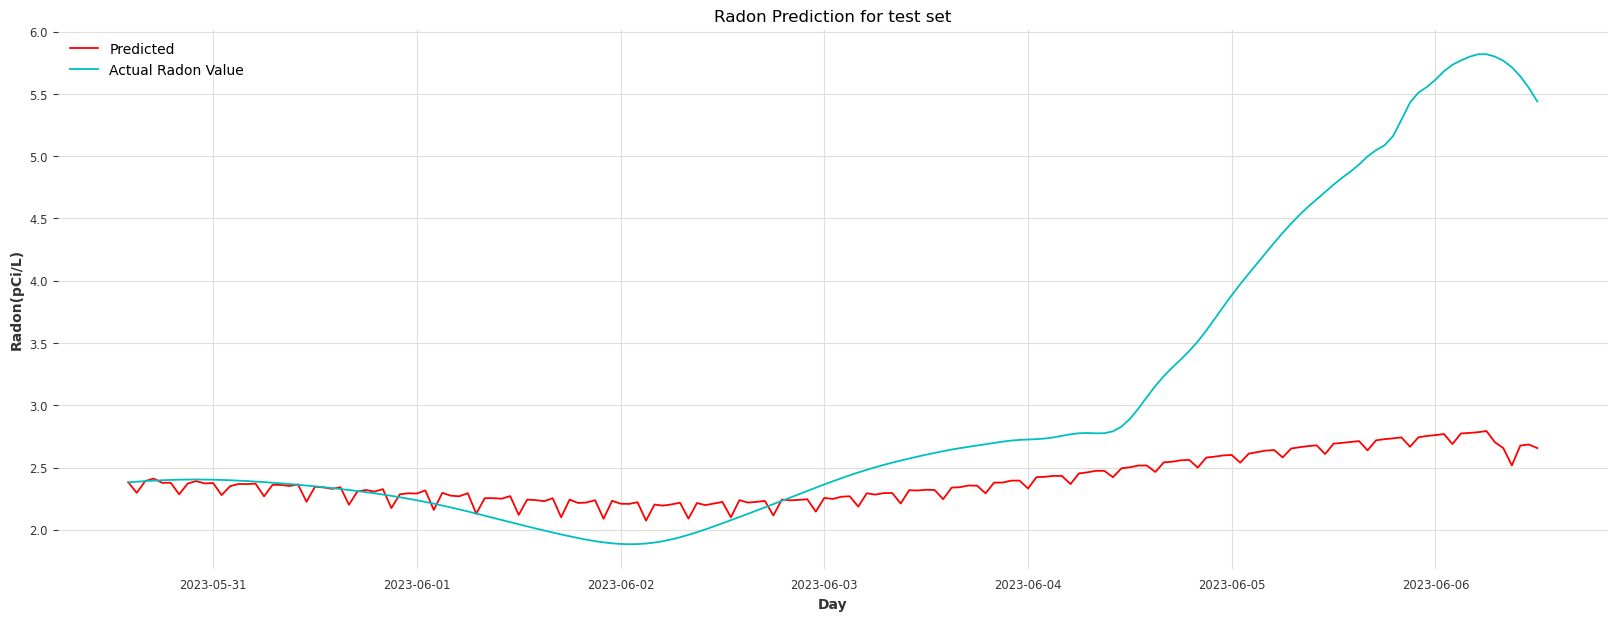

In [35]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()